<a href="https://colab.research.google.com/github/NilsBahr94/Churn-Analysis-CRM/blob/master/Master_Thesis_Algorithmic_Bias_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

## Import packages

In [ ]:
# Install relevant libraries
!pip install plotnine  
!pip install pandas
!pip install plotly
!pip install datatable

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotnine import *
from pandas import DataFrame

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import collections

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
# Import train_test_split
from sklearn.model_selection import train_test_split
# Import accuracy_score
from sklearn.metrics import accuracy_score

# Learning Curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

# Model Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

import sklearn.metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
# Setup classifiers 
# a) Linear
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# b) Nonlinear
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
# c) Others
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Data Visualization with ggplot2
from pandas.api.types import CategoricalDtype
from plotnine import *
from plotnine.data import mpg

# Model Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import sklearn.metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Function Definitions

In [2]:
pd.set_option('display.max_columns', None)

# HYPERPARAMETER TUNING

def hyperparameter_tuning(df_train_input, df_train_label, cv):

  from sklearn import model_selection

  # Create the hyperparameter grid
  # Important: Keys in the dictionary must be valid hyperparameters 
  param_grid = {"learning_rate": [0.2],
                "n_estimators": [50, 100, 150],
                "max_depth": [3, 6, 9],
                "min_child_weight": [1, 3, 5], 
                "reg_lambda": [1, 1.2]}

  xgb_grid_search = XGBClassifier(objective= 'binary:logistic', nthread=4)

  # Learning Curve for Slice 
  from sklearn.metrics import make_scorer
  from sklearn.metrics import f1_score

  # Define model
  f1 = make_scorer(f1_score)

  # Dummy Coding
  df_train_input_dummy = pd.get_dummies(df_train_input)

  grid_rf_class = sklearn.model_selection.GridSearchCV(estimator = xgb_grid_search,
                                                      param_grid = param_grid, 
                                                      scoring= f1,
                                                      n_jobs = 2, 
                                                      cv = cv,
                                                      refit = True,
                                                      return_train_score = False)
  
  # Fit model
  grid_rf_class.fit(df_train_input_dummy, df_train_label)

  print(grid_rf_class.best_params_)
  print(grid_rf_class.best_estimator_) 

  return(grid_rf_class)

def eda_descr_stats(data, disc_feature, disc_min_value, label, second_disc_feature=""):

  # 1. Sensitive Feature
  print(f"1. Sensitive Attribute: One or more of the following features are sensitive ones: {data.columns}.")
  print(f"1. Sensitive Attribute: These are the individual values for the sensitive attribute: {data[disc_feature].unique()}.")

  # 2. Binary Target Feature
  print("2. Binary Target Variable: The Binary Target Feature has the following values and counts:")
  print(data.groupby([label]).agg({label: 'count'}))

  # 3. Total Number of Predictor Features
  print(f"3. The Total Number of Predictor Features is: {data.shape[1]}.")

  # 4. Total Number of Training Examples
  print(f"4. The Total Number of Training Examples is: {data.shape[0]}.")

  # 5. Total Number of Training Examples in the Minority Group 
  is_min = data[disc_feature].isin([disc_min_value])
  print(f"5. The Total Number of Training Examples in the Minority Group is: {len(data[is_min].index)}.")

  # 6. Sample Size Disparity
  # Absolute number of members of different "races"
  print(f"6. Sample Size Disparity: The Absolute numbers of members of different races are as follows:  {data[disc_feature].value_counts(dropna=False, sort=True)}.")
  # Percentage of members of different "races"
  print(f"6. Sample Size Disparity: The Percentages of the number of members of different races are as follows: {data[disc_feature].value_counts(normalize=True, dropna=False, sort=True)}.")

  # 7. Class Balance
  print("7. Class Balance: The Class Balance looks as follows:")
  print(data[label].value_counts(dropna=False))
  print(data[label].value_counts(normalize=True, dropna=False))

  # 8. Coarseness of Features
  print("8. Coarseness of Features: Details on missing values of features in the dataset:")
  print(data.apply(lambda x: x.isna().sum()))
  print(data.groupby(disc_feature).apply(lambda x: x.isna().sum()))
  print(data.groupby(disc_feature).apply(lambda x: x.isna().mean()))

  # 9. Severity of Outliers for Numeric Features
  print("9. Severity of Outliers for Numeric Features")
  ax = sns.boxplot(data=data, orient="h", palette="Set2")
  print(ax)

  # (10. Cross-sectional sample size disparity)
  if second_disc_feature:
    print("10. Cross-sectional sample size disparity")
    data.groupby([second_disc_feature, disc_feature]).agg({label: 'count'})

# Define Data Preprocessing Function

def fair_preprocess(data, label, neg_class, pos_class):

  ''' Applies binary encoding on the values of the label feature.

  Returns two datasets in the following order: data_input_features and data_label. '''

  # Binary encoding
  data[label] = data[label].replace({neg_class: 0, pos_class: 1})

  # Create separate dataset version for input features and label
  data_input_features = data.drop(columns=[label])
  data_label = data[label]

  return data_input_features, data_label


# Function to create datasets with different minority group sizes

def create_datasets(min_data: pd.DataFrame, maj_data: pd.DataFrame, training_sizes: list):
    datasets = []
    for training_size in training_sizes:
      if abs(training_size) <= len(min_data.index):
        dataset_min_sample = min_data.sample(n=training_size)
        dataset = pd.concat((dataset_min_sample, maj_data))
        datasets.append(dataset)
      else:
        break
    print(len(datasets))
    print([df.shape[0] for df in datasets])
    return datasets

def metrics_to_df(list_dfs, label, model, cv, discr_feature, min_value, maj_value):

  # Import relevant modules
  import numpy as np
  from sklearn.model_selection import cross_val_predict
  from sklearn.model_selection import cross_validate
  import sklearn.metrics
  from sklearn.metrics import make_scorer
  from sklearn.metrics import f1_score
  from sklearn.metrics import recall_score
  from sklearn.metrics import confusion_matrix
  from sklearn.ensemble import RandomForestClassifier

  # Initialize lists for metrics 
  # COMPLETE
  rows_compl_list = [] 
  f1_compl_list = []
  f1_avg_train_score_list = []
  tpr_compl_list = []
  # MINORITY
  rows_min_list = [] 
  f1_min_list = []
  tpr_min_list = []
  fpr_min_list = []
  prob_y_1_min_list = []
  # MAJORITY
  rows_maj_list = []
  f1_maj_list = []
  tpr_maj_list = []
  fpr_maj_list = []
  prob_y_1_maj_list = []


  for dataset_var in list_dfs:

      # Define Input and target columns
      df_train_input = dataset_var.drop(columns=[label])  # Input
      df_train_label = dataset_var[label]                 # Target

      # Apply dummy coding
      df_train_input = pd.get_dummies(df_train_input)

      ## TRAIN & TEST
      # Predict 
      y_train_pred = cross_val_predict(model,
                                       df_train_input,
                                       df_train_label,
                                       cv = cv)

      # Append prediction labels to original dataset
      dataset_var['y_pred'] = y_train_pred

      # Create dataset for MINORITY group 
      is_black = dataset_var[discr_feature].isin([min_value])
      df_check_black = dataset_var[is_black] 

      # Create dataset for MAJORITY group
      is_white = dataset_var[discr_feature].isin([maj_value])
      df_check_white = dataset_var[is_white] 

      ## METRICS
      # Get metrics for the COMPLETE dataset
      # NUMBER OF ROWS
      rows_compl = len(dataset_var.index)
      rows_compl_list.append(rows_compl)   
      # F1 test scores
      f1_compl = f1_score(df_train_label, y_train_pred) 
      f1_compl_list.append(f1_compl) 
      # F1 training scores
      f1 = make_scorer(f1_score)
      cross_val_results = cross_validate(estimator = model, 
                                         X = df_train_input, 
                                         y = df_train_label, 
                                         cv = cv, 
                                         scoring = f1, 
                                         return_train_score=True)
      f1_avg_train_score = np.mean(cross_val_results["train_score"])
      f1_avg_train_score_list.append(f1_avg_train_score)
      # Recall
      tpr_compl = recall_score(df_train_label, y_train_pred)
      tpr_compl_list.append(tpr_compl)

      # Get metrics for the MINORITY group
      # NUMBER OF ROWS
      rows_min = len(df_check_black.index)
      rows_min_list.append(rows_min)
      # F1
      f1_min = f1_score(df_check_black[label], df_check_black["y_pred"], labels=np.unique(df_check_black["y_pred"]))  # or labels = [0,1]
      f1_min_list.append(f1_min)
      # TPR/RECALL
      tpr_min = recall_score(df_check_black[label], df_check_black["y_pred"], labels=np.unique(df_check_black["y_pred"]))
      tpr_min_list.append(tpr_min)
      # FPR/SPECIFICITY
      tn_min, fp_min, fn_min, tp_min = confusion_matrix(df_check_black[label], df_check_black["y_pred"], labels=[0,1]).ravel()
      fpr_min = fp_min / (fp_min+tn_min)
      fpr_min_list.append(fpr_min)
      # Cond. Prob. P(y_min=1|minority)
      filter_race_black_y_1 = dataset_var[discr_feature].isin([min_value]) & dataset_var["y_pred"].isin([1])
      filter_race_black = dataset_var[discr_feature].isin([min_value])
      prob_y_1_min = len(dataset_var[filter_race_black_y_1].index) / len(dataset_var[filter_race_black].index)
      prob_y_1_min_list.append(prob_y_1_min)

      # Get metrics for the MAJORITY group
      # NUMBER OF ROWS
      rows_maj = len(df_check_white.index)
      rows_maj_list.append(rows_maj)
      # F1
      f1_maj = f1_score(df_check_white[label], df_check_white["y_pred"], labels=np.unique(df_check_black["y_pred"]))
      f1_maj_list.append(f1_maj)
      # TPR/RECALL
      tpr_maj = recall_score(df_check_white[label], df_check_white["y_pred"], labels=np.unique(df_check_black["y_pred"])) 
      tpr_maj_list.append(tpr_maj)
      # FPR/SPECIFICITY
      tn_maj, fp_maj, fn_maj, tp_maj = confusion_matrix(df_check_white[label], df_check_white["y_pred"], labels=[0,1]).ravel()
      fpr_maj = fp_maj / (fp_maj+tn_maj)
      fpr_maj_list.append(fpr_maj)
      # Cond. Prob. P(y_maj=1|majority)
      filter_race_white_y_1 = dataset_var[discr_feature].isin([maj_value]) & dataset_var["y_pred"].isin([1])
      filter_race_white = dataset_var[discr_feature].isin([maj_value])
      prob_race_white_y_1 = len(dataset_var[filter_race_white_y_1].index) / len(dataset_var[filter_race_white].index)
      prob_y_1_maj_list.append(prob_race_white_y_1)

  # Store metrics for different iterations in Data Frame
  results_df = pd.DataFrame({'rows_complete': rows_compl_list,
                             "rows_minority": rows_min_list,
                             "rows_majority": rows_maj_list, 
                             'f1_complete': f1_compl_list,
                             "f1_complete_train": f1_avg_train_score_list,
                             'f1_minority': f1_min_list,
                             'f1_majority': f1_maj_list,
                             "tpr_complete": tpr_compl_list,
                             'tpr_minority': tpr_min_list,
                             "tpr_majority": tpr_maj_list,
                             "fpr_minority": fpr_min_list,
                             "fpr_majority": fpr_maj_list,
                             "prob_yhat_1_minority": prob_y_1_min_list,
                             "prob_yhat_1_majority": prob_y_1_maj_list})

  # Calculate new metric columns and append to df 
  results_df["rel_share_min_of_maj"] = (results_df["rows_minority"] / results_df["rows_majority"])
  # FAIRNESS METRICS
  # Average Absolute Odds Difference -> The closer to 0, the fairer.
  results_df["aver_abs_odds_diff"] = 0.5*(abs(results_df["fpr_minority"] - results_df["fpr_majority"])+abs(results_df["tpr_minority"] - results_df["tpr_majority"])) 
  # Statistical Parity Difference -> The closer to 0, the fairer.
  results_df["stat_parity_diff"] =  results_df["prob_yhat_1_minority"] - results_df["prob_yhat_1_majority"]
  # Equal Opportunity Distance -> The closer to 0, the fairer.
  results_df["equal_opport_dist"] = results_df["tpr_minority"] - results_df["tpr_majority"]  
  # Disparate Impact -> The closer to 1, the fairer.
  results_df["disparate_impact"] =  results_df["prob_yhat_1_minority"] / results_df["prob_yhat_1_majority"]

  return(results_df)

# Learning Curve https://www.kaggle.com/grfiv4/learning-curves-1

import numpy  as np
import pandas as pd

def plot_learning_curve(estimator, title, X, y, 
                        ylim=None, cv=None, 
                        scoring=None, obj_line=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    scoring : string, callable or None, optional, default: None
              A string (see model evaluation documentation)
              or a scorer callable object / function with signature scorer(estimator, X, y)
              For Python 3.5 the documentation is here:
              http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
              For example, Log Loss is specified as 'neg_log_loss'
              
    obj_line : numeric or None (default: None)
               draw a horizontal line 
               

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        
        
    Citation
    --------
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
        
    Usage
    -----
        plot_learning_curve(estimator = best_estimator, 
                            title     = best_estimator_title, 
                            X         = X_train, 
                            y         = y_train, 
                            ylim      = (-1.1, 0.1), # neg_log_loss is negative
                            cv        = StatifiedCV, # CV generator
                            scoring   = scoring,     # eg., 'neg_log_loss'
                            obj_line  = obj_line,    # horizontal line
                            n_jobs    = n_jobs)      # how many CPUs

         plt.show()
    """
    
    from sklearn.model_selection import learning_curve
    import numpy as np
    from matplotlib import pyplot as plt
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()

    # plt.style.use('seaborn')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    if obj_line:
        plt.axhline(y=obj_line, color='blue')

    plt.legend(loc="best")
    return plt

# Minority Line Chart - Function Definition

def min_metrics_line_chart(metric_df, title):

  import plotly.graph_objects as go
  
  # Create traces

  # Performance Metrics
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=metric_df["rows_minority"], y=metric_df["f1_minority"],
                      mode='lines+markers',
                      name='F1 Minority'))
  fig.add_trace(go.Scatter(x=metric_df["rows_minority"], y=metric_df["tpr_minority"],
                      mode='lines+markers',
                      name='TPR/Recall Minority'))
  fig.add_trace(go.Scatter(x=metric_df["rows_minority"], y=metric_df["fpr_minority"],
                      mode='lines+markers',
                      name='FPR Minority'))
  # Fairness Metrics
  fig.add_trace(go.Scatter(x=metric_df["rows_minority"], y=metric_df["aver_abs_odds_diff"],
                      mode='lines+markers',
                      name='Avg. Abs. Odds Difference'))
  fig.add_trace(go.Scatter(x=metric_df["rows_minority"], y=metric_df["stat_parity_diff"],
                      mode='lines+markers',
                      name='Statistical Parity Difference'))
  fig.add_trace(go.Scatter(x=metric_df["rows_minority"], y=metric_df["equal_opport_dist"],
                      mode='lines+markers',
                      name='Equal Opportunity Distance'))
  fig.add_trace(go.Scatter(x=metric_df["rows_minority"], y=metric_df["disparate_impact"],
                      mode='lines+markers',
                      name='Disparate Impact'))

  # Edit the layout
  fig.update_layout(title={'text': title,
                           'y':0.9,
                           'x':0.5,
                           # 'xanchor': 'center',
                           'yanchor': 'top'},
                    xaxis_title='Rows Minority',
                    yaxis_title='Metric Score', 
                    font=dict(size=14))

  fig.show()

# Majority <-> Minority Line Chart - Function Definition

def maj_min_metrics_line_chart(metric_df, title):

  import plotly.graph_objects as go

  # Create traces

  # Performance Metrics
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=metric_df["rows_complete"], y=metric_df["f1_majority"],
                      mode='lines+markers',
                      name='F1 Majority'))
  fig.add_trace(go.Scatter(x=metric_df["rows_complete"], y=metric_df["f1_minority"],
                      mode='lines+markers',
                      name='F1 Minority'))
  # TPR
  fig.add_trace(go.Scatter(x=metric_df["rows_complete"], y=metric_df["tpr_majority"],
                      mode='lines+markers',
                      name='TPR/Recall Majority'))
  fig.add_trace(go.Scatter(x=metric_df["rows_complete"], y=metric_df["tpr_minority"],
                      mode='lines+markers',
                      name='TPR/Recall Minority'))
  # FPR
  fig.add_trace(go.Scatter(x=metric_df["rows_complete"], y=metric_df["fpr_majority"],
                      mode='lines+markers',
                      name='FPR Majority'))
  fig.add_trace(go.Scatter(x=metric_df["rows_complete"], y=metric_df["fpr_minority"],
                      mode='lines+markers',
                      name='FPR Minority'))

  # Edit the layout
  fig.update_layout(title={'text': title,
                           'y':0.9,
                           'x':0.5,
                           # 'xanchor': 'center',
                           'yanchor': 'top'},
                    xaxis_title='Rows Complete',
                    yaxis_title='Metric Score', 
                    font=dict(size=14))

  fig.show()

def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

# Case Studies

## 0) Testing

#### Hyperparameter Tuning

In [ ]:
# Hyperparameter Tuning

best_classifier_adult = hyperparameter_tuning(df_3_adult_train_input, df_3_adult_train_label, cv = 5)

# Resulting Model

# {'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'reg_lambda': 1}
# XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=1, gamma=0,
#               learning_rate=0.3, max_delta_step=0, max_depth=6,
#               min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
#               nthread=None, objective='binary:logistic', random_state=0,
#               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
#               silent=None, subsample=1, verbosity=1)

In [ ]:
best_classifier_compas = hyperparameter_tuning(df_compas_train_input, df_compas_train_label, cv = 5)

NameError: ignored

In [ ]:
best_classifier_homicide = hyperparameter_tuning(df_homicide_train_input, df_homicide_train_label, cv = 5)

TerminatedWorkerError: ignored

In [ ]:
best_classifier_credit = hyperparameter_tuning(df_credit_train_input, df_credit_train_label, cv = 5)

{'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'reg_lambda': 1.2}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1.2, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

#### Learning Curves: Compare diff. algorithms

Selection of classification method:

- **Linear** machine learning algorithms often have a high bias but a low variance.
    1. Logistic Regression
    2. Linear Discriminant Analysis
    3. Partial Least Squares Discriminant Analysis
- **Nonlinear** machine learning algorithms often have a low bias but a high variance.
    1. Nonlinear Discriminant Analysis
    2. Neural Networks
    3. Flexible Discriminant Analysis
    4. Support Vector Machines 
    5. K-Nearest Neighbors
    6. Naive Bayes
- Others
    1. Basic Classification Trees
    2. Random Forest
    3. Boosted Trees - XGBoost

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# Setup classifiers 
# a) Linear
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# b) Nonlinear
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
# c) Others
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


# Define different classification algorithms
random_forest = RandomForestClassifier(n_estimators = 100, max_leaf_nodes = 12)
# knn = KNeighborsClassifier(n_neighbors = 5)
log_reg = LogisticRegression()
svm = SVC(C = 1.0, kernel = "rbf")

# Store different models in a list
models = [random_forest, log_reg, svm]

# Define other input arguments
f1 = make_scorer(f1_score) # theoretically, set (zero_division=1)
sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300,
             350, 400, 450, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750,
             2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500,
             4750, 5000, 6000, 7000, 8000, 9000, 10000, 15000]

# Plot learning curve for different classifcation algorithms
for model in models:
  plt.subplot
  plot_learning_curve(estimator = model, 
                      title = f"{model} Learning Curve", 
                      X = df_3_adult_train_input, y = df_3_adult_train_label, 
                      cv = 10, 
                      scoring = f1, 
                      ylim = (0, 1), 
                      train_sizes = sizes)

# Plot different subplots 

# for model, i in [(RandomForestClassifier(), 1), (KNeighborsClassifier(),2)]:
#     plt.subplot(1,2,i)
#     learning_curves(estimator = model, 
#                     data = df_3_adult_dummies, 
#                     features = df_3_adult_train_input.columns, 
#                     target= "Over-50K", 
#                     train_sizes = train_sizes, 
#                     cv= 5)

In [ ]:
# def data_preprocess_fair(full_dataset, 
#                          outcome_feature, 
#                          privileged_outcome_label, 
#                          discriminatory_feature, 
#                          majority_label,
#                          minority_label)


## 1) Convert the labels of the target variable into a suitable  format (binary integer)
# Encoding Binary 
df_3_adult["Over-50KVariables"] = df_3_adult["Over-50K"].apply(lambda val: 1 if val == ">50K" 
                                                               else 0)

# Check if encoding was successful 
df_3_adult["Over-50K"].dtypes

## 2. Prepare data for training (input features and label).
# Features of complete dataset
# print(df_3_adult.columns)

# Input features
df_3_adult_train_input = df_3_adult.drop(columns=["Over-50K"])
# print(df_3_adult_train_input.columns)

# Target feature
df_3_adult_train_label = df_3_adult["Over-50K"]
# print(df_3_adult_train_label)

## 3) Prepare data as such that machine learning classification algorithm can handle that properly (e.g. standardization, normalization, feature scaling, dummy encoding)
# Dummy 
df_3_adult_train_input = pd.get_dummies(df_3_adult_train_input)

## 4) Filter dataset based on certain feature values which identify subpopulations and create different dataset versions based on that
# Setup slices of the dataset
is_black = df_3_adult["Race"].isin(["Black"])
is_white = df_3_adult["Race"].isin(["White"])
is_female = df_3_adult["Sex"].isin(["Female"])
is_male = df_3_adult["Sex"].isin(["Male"])

# Create filtered version of the dataset
# Minority group
df_3_adult_black = df_3_adult[is_black]
df_3_adult_female = df_3_adult[is_female]
# Majority group
df_3_adult_white = df_3_adult[is_white]
df_3_adult_male = df_3_adult[is_male]

# print(df_3_adult.shape)
# print(df_3_adult_black.shape)
# print(df_3_adult_white.shape)
# print(df_3_adult_female.shape)
# print(df_3_adult_male.shape)


  # """
  #   Convert the target label in an binary number format, create two different datasets sets 

  #   Parameters
  #   ----------
  #   estimator : object type that implements the "fit" and "predict" methods
  #       An object of that type which is cloned for each validation.

  #   title : string
  #       Title for the chart.

  #   X : array-like, shape (n_samples, n_features)
  #       Training vector, where n_samples is the number of samples and
  #       n_features is the number of features.

  #   y : array-like, shape (n_samples) or (n_samples, n_features), optional
  #       Target relative to X for classification or regression;
  #       None for unsupervised learning.

  #   ylim : tuple, shape (ymin, ymax), optional
  #       Defines minimum and maximum yvalues plotted.

  # """

In [ ]:
import xgboost
from xgboost import XGBClassifier
model = xgboost.XGBClassifier()

## 1) US Adult Income Dataset

UCI Adult dataset, also known as "Census Income" dataset, contains information, extracted from the 1994 census data about people with attributes such as age, occupation, education, race, sex, marital-status, native-country, hours-per-week etc., indicating whether the income of a person exceeds $50K/yr or not. It can be used in fairness-related studies that want to compare gender or race inequalities based on people’s annual incomes, or various other studies [6]. 

### Data Import

In [ ]:
# DATA IMPORT

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Set the path to the CSV containing the dataset to train on.
csv_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

# Set the column names for the columns in the CSV. If the CSV's first line is a header line containing
# the column names, then set this to None.
csv_columns = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital-Status",
               "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss",
               "Hours-per-week", "Country", "Over-50K"]

# Read the dataset from the provided CSV and print out information about it.
df_3_adult = pd.read_csv(csv_path, names=csv_columns, skipinitialspace=True)

In [ ]:
df_3_adult.groupby(["Over-50K"]).agg({"Over-50K": 'count'})

### Initial Data Preprocessing

Shrink the size of the Dataframe

In [ ]:
df_3_adult.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education-Num      int64
Marital-Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital-Gain       int64
Capital-Loss       int64
Hours-per-week     int64
Country           object
Over-50K          object
dtype: object

In [ ]:
# Check which columns are suitable for conversion in "category" data format
## We should stick to using the category type primarily for object columns where less than 50% of the values are unique.
df_3_adult_copy = df_3_adult.select_dtypes(include=['object']).copy()
df_3_adult_copy.describe()

,Workclass,Education,Marital-Status,Occupation,Relationship,Race,Sex,Country,Over-50K
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [ ]:
# Reduce the size of the numeric columns

df_3_adult, NAlist = reduce_mem_usage(df_3_adult)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

In [ ]:
for col in ["Workclass", "Education","Marital-Status","Occupation","Relationship","Race","Sex","Country","Over-50K"]:
    df_3_adult[col] = df_3_adult[col].astype('category')

### Exploratory Data Analysis

1. Sensitive Feature 	
  - Features are included which could lead to discrimination (e.g. Race, Sexual Orientation, Color, National Origin, Citizenship, Familiar Status, Pregnancy, Disability Status) and on the basis of which groups in the data can be assigned to the majority or minority group.  

2. Binary Target Feature Y ∈ {0, 1}: 
  - The target variable should reflect allocative harms (= allocation of limited opportunities, resources, or information).

3. Total Number of Predictor Features	

  - Number of predictor features on the basis of which a mapping to a target variable is carried out. Partly representative of the complexity of the prediction problem at hand.

4. Total Number of Training Examples 	
  - Total number of training examples in the dataset.

5. Total Number of Training Examples in the Minority Group
  - Number of training examples per value of a sensitive attribute.

6. Sample Size Disparity	
  - Sample size disparity is represented by the difference between the relative share of the minority and the majority group.

7. Class Balance	
  - Percentage of examples with 1 and 0 in the majority group, in the minority groupas well as in the complete dataset.

8. Coarseness of Features	
  - Features might be less reliably collected for minority groups. 
  - Represented by percent of missing values for the subpopulations per feature for the examined training data interval 

9. Feature Importance	
  - The predictive power of the features represent how much contribution the features have brought in average in order to derive at the final predictions. 
  - The distribution of the predictive power of the features should be even for different datasets.

In [ ]:
print(df_3_adult.info)
print(df_3_adult.describe())
print(df_3_adult.columns)

In [ ]:
eda_descr_stats(data = df_3_adult, disc_feature= "Race", disc_min_value="Black", label = "Over-50K")

### Data Analysis


###### 0) Preprocess data.

In [ ]:
# Execute preprocessing function
df_3_adult_train_input, df_3_adult_train_label = fair_preprocess(data = df_3_adult, 
                                                                 label = "Over-50K", 
                                                                 neg_class = "<=50K", 
                                                                 pos_class = ">50K")

In [ ]:
# Check whether binary encoding was successful and seperate datasets were created
print(df_3_adult.groupby(["Over-50K"]).agg({"Over-50K": 'count'}))
print(df_3_adult_train_input.columns)

###### 1) Define hyperparameters.

Get Feature Importance

In [ ]:
grid_rf_class_adult = hyperparameter_tuning(df_train_input = df_3_adult_train_input, df_train_label= df_3_adult_train_label)

print(grid_rf_class_adult.best_params_)
print(grid_rf_class_adult.best_estimator_) # print in order to check actual final hyperparameters

cv_results_df = pd.DataFrame(grid_rf_class_adult.cv_results_)
best_row = cv_results_df[cv_results_df["rank_test_score"] == 1]
print(best_row)
print(cv_results_df)

Hyperparameter Tuning

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [ ]:
# HYPERPARAMETER TUNING - XGBoost

from sklearn import model_selection

param_grid = {"learning_rate": [0.3],
              "n_estimators": [80],
              "max_depth": [5], 
              "min_child_weight": [1], 
              "reg_lambda": [1]}

xgb_grid_search = XGBClassifier(objective= 'binary:logistic', nthread=4)
cv=3

# Learning Curve for Slice 
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# Define model
f1 = make_scorer(f1_score)

# Dummy Coding
df_3_adult_train_input = pd.get_dummies(df_3_adult_train_input)

grid_rf_class = sklearn.model_selection.GridSearchCV(estimator = xgb_grid_search,
                                                     param_grid = param_grid, 
                                                     scoring= f1, 
                                                     cv = cv,
                                                     refit = True,
                                                     return_train_score = False)

# Fit model
grid_rf_class.fit(df_3_adult_train_input, df_3_adult_train_label) 

print(grid_rf_class.best_params_)
print(grid_rf_class.best_estimator_) # print in order to check actual final hyperparameters

# cv_results_df = pd.DataFrame(grid_rf_class.cv_results_)
# best_row = cv_results_df[cv_results_df["rank_test_score"] == 1]
# print(best_row)
# print(cv_results_df)

{'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 80, 'reg_lambda': 0.9}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=80, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0.9, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


###### 2) Create datasets with diff. minority group sizes.

First, take the whole dataset with the majority and the minority class. Then, filter the dataset such that the majority class is fixed in size and only a certain number of training examples that are considered for the minority class is considered. Change this number step-by-step. 

In [ ]:
# Determine number of training examples for the examples that are at risk of being discriminated
print(df_3_adult.groupby(['Race', "Over-50K"]).agg({"Over-50K": 'count'}))

                             Over-50K
Race               Over-50K          
Amer-Indian-Eskimo 0              275
                   1               36
Asian-Pac-Islander 0              763
                   1              276
Black              0             2737
                   1              387
Other              0              246
                   1               25
White              0            20699
                   1             7117


In [ ]:
# Define arguments

training_sizes = [5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350, 400, 450, 500, 600, 
                  700, 800, 900, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 
                  4000, 4250, 4500, 4750, 5000, 6000, 7000, 8000, 9000, 10000, 15000]

# Creating dfs for minority and majority group
is_black = df_3_adult["Race"].isin(["Black"])
is_white = df_3_adult["Race"].isin(["White"])
df_3_adult_black = df_3_adult[is_black]  # Minority
df_3_adult_white = df_3_adult[is_white]  # Majority

# Execute function
list_dfs_adult = create_datasets(min_data = df_3_adult_black, maj_data = df_3_adult_white, training_sizes = training_sizes)

31
[27821, 27826, 27836, 27846, 27856, 27866, 27891, 27916, 27941, 27966, 27991, 28016, 28066, 28116, 28166, 28216, 28266, 28316, 28416, 28516, 28616, 28716, 28816, 29066, 29316, 29566, 29816, 30066, 30316, 30566, 30816]


In [ ]:
df_test = list_dfs_adult[15]
print(df_test.groupby(["Over-50K"]).agg({"Over-50K": 'count'}))

          Over-50K
Over-50K          
0            21046
1             7170


###### 3) Create dataframe with diff. metrics.

In [ ]:
# Define arguments
list_dfs = list_dfs_adult
label = "Over-50K"
adult_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=80, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# model = grid_rf_class # <- Best model from hyperparameter tuning
cv = 10
discr_feature = "Race"
min_value = "Black"
maj_value = "White"

# Execute function
results_df_adult = metrics_to_df(list_dfs = list_dfs_adult, label = label, model = adult_model, cv = cv, 
                                 discr_feature = discr_feature, min_value = min_value, maj_value = maj_value)

results_df_adult

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.



,rows_complete,rows_minority,rows_majority,f1_complete,f1_complete_train,f1_minority,f1_majority,tpr_complete,tpr_minority,tpr_majority,fpr_minority,fpr_majority,prob_yhat_1_minority,prob_yhat_1_majority,rel_share_min_of_maj,aver_abs_odds_diff,stat_parity_diff,equal_opport_dist,disparate_impact
0,27821,5,27816,0.714187,0.756365,0.000000,0.714187,0.653225,0.000000,0.653225,0.000000,0.060534,0.000000,0.212180,0.000180,0.356879,-0.212180,-0.653225,0.000000
1,27826,10,27816,0.711844,0.760895,0.000000,0.711844,0.649431,0.000000,0.649431,0.000000,0.060244,0.000000,0.210994,0.000360,0.354838,-0.210994,-0.649431,0.000000
2,27836,20,27816,0.713683,0.756079,1.000000,0.713596,0.653884,1.000000,0.653787,0.000000,0.061404,0.100000,0.212971,0.000719,0.203809,-0.112971,0.346213,0.469548
3,27846,30,27816,0.712046,0.757311,0.666667,0.712077,0.653609,0.600000,0.653646,0.040000,0.062660,0.133333,0.213870,0.001079,0.038153,-0.080536,-0.053646,0.623433
4,27856,40,27816,0.712786,0.756766,0.500000,0.712917,0.653096,0.333333,0.653365,0.000000,0.061742,0.050000,0.213115,0.001438,0.190887,-0.163115,-0.320032,0.234615
5,27866,50,27816,0.710958,0.757652,0.842105,0.710768,0.653150,0.800000,0.652944,0.025000,0.063385,0.180000,0.214229,0.001798,0.092721,-0.034229,0.147056,0.840222
6,27891,75,27816,0.707116,0.758356,0.714286,0.707108,0.648470,0.555556,0.648588,0.000000,0.063916,0.066667,0.213510,0.002696,0.078474,-0.146844,-0.093032,0.312241
7,27916,100,27816,0.708273,0.758556,0.736842,0.708231,0.648008,0.636364,0.648026,0.011236,0.062563,0.080000,0.212360,0.003595,0.031495,-0.132360,-0.011662,0.376719
8,27941,125,27816,0.709747,0.754835,0.685714,0.709811,0.648164,0.705882,0.648026,0.055556,0.061162,0.144000,0.211317,0.004494,0.031732,-0.067317,0.057856,0.681440
9,27966,150,27816,0.711309,0.755391,0.608696,0.711490,0.651235,0.636364,0.651258,0.035971,0.061694,0.080000,0.212540,0.005393,0.020308,-0.132540,-0.014894,0.376401


In [ ]:
# Save metrics csv
results_df_adult.to_csv("df_adult_metrics.csv") 
from google.colab import files
files.download("df_adult_metrics.csv")

###### 4) Create visualizations.

In [ ]:
# Get Feature Importance
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

model = XGBClassifier()
model.fit(df_compas_train_input, df_compas_train_label)
plot_importance(model)
pyplot.show()

In [ ]:
# B: Learning Curve Function from scikit learn
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from matplotlib.pyplot import figure

# Define arguments
f1 = make_scorer(f1_score) 

df_3_adult_train_input = pd.get_dummies(df_3_adult_train_input)

# Plot actual learning curve
plot_learning_curve(estimator = model, 
                    title = "Adult Dataset - Random Forest Learning Curve", 
                    X = df_3_adult_train_input, y = df_3_adult_train_label, 
                    cv = 5, 
                    scoring = f1, 
                    ylim = (0, 1), 
                    train_sizes = np.linspace(.1, 1.0, 10))

Minority Line Chart 

In [ ]:
min_metrics_line_chart(metric_df = results_df_adult, title="Minority Metrics for the Adult Dataset with XGBoost")

Majority <-> Minority Line Chart 

In [ ]:
maj_min_metrics_line_chart(metric_df=results_df_adult, title="Majority and Minority Metrics for the Adult Dataset with XGBoost") 

## 2) COMPAS Dataset

### Data Import

In [ ]:
path_compas = "/content/drive/My Drive/Master Thesis/Data/compas-scores-two-years_dataset.csv"
compas_column_names = ['id', 'name', 'first', 'last', 'compas screening date', 'sex', 'dob',
                       'age', 'age cat', 'race', 'juv fel count', 'decile score',
                       'juv misd count', 'juv other count', 'priors count',
                       'days b screening arrest', 'c jail in', 'c jail out', 'c case number',
                       'c offense date', 'c arrest date', 'c days from compas',
                       'c charge degree', 'c charge desc', 'is recid', 'r case number',
                       'r charge degree', 'r days from arrest', 'r offense date',
                       'r charge desc', 'r jail in', 'r jail out', 'violent recid',
                       'is violent recid', 'vr case number', 'vr charge degree',
                       'vr offense date', 'vr charge desc', 'type of assessment',
                       'decile score.1', 'score text', 'screening date',
                       'v type of assessment', 'v decile score', 'v score text',
                       'v screening date', 'in custody', 'out custody', 'priors count.1',
                       'start', 'end', 'event', 'two year recid']
df_compas = pd.read_csv(path_compas, low_memory=False, names = compas_column_names, header = 0, sep = ";")

### Initial Data Preprocessing

In [ ]:
# Rename columns
df_compas = df_compas.rename(index=str, columns={"decile score.1":"decile_score a",
                                                 "priors count.1":"priors_count a"})

# Replace empty strings with NAs
df_compas = df_compas.replace(r'^\s*$', np.nan, regex=True)

# Drop unnecessary columns
df_compas = df_compas.drop(['id', 'name', 'age cat', "is recid", "event", "start", "end"], axis=1)

# Drop NaN from label column 
df_compas = df_compas[df_compas['two year recid'].notna()]
print(df_compas.shape)

# Convert columns to datetime format
# Columns with yyyy-mm-dd format:
# date_columns = ["dob", "c_offense_date", "c_arrest_date", "r_offense_date", "r_jail_out", "vr_offense_date", "screening_date", "v_screening_date", "v_screening_date", "in_custody", "out_custody"]
# for date_time in date_columns:
#   df_compas[date_time]= pd.to_datetime(df_compas[date_time])

# To Do: Columns with yyyy-mm-dd and hh:mm:ss -> c_jail_in, c_jail_out

(6873, 46)


Shrink the size of the Dataframe

In [ ]:
df_compas.dtypes

In [ ]:
# Check which columns are suitable for conversion in "category" data format
## We should stick to using the category type primarily for object columns where less than 50% of the values are unique.
df_compas_copy = df_compas.select_dtypes(include=['object']).copy()
df_compas_copy.describe()

,first,last,compas screening date,sex,dob,race,c jail in,c jail out,c case number,c offense date,c arrest date,c charge degree,c charge desc,r case number,r charge degree,r offense date,r charge desc,r jail in,r jail out,vr case number,vr charge degree,vr offense date,vr charge desc,type of assessment,score text,screening date,v type of assessment,v score text,v screening date,in custody,out custody
count,6873,6873,6873,6873,6873,6873,6574,6574,6852,5768,1084,6873,6847,3295,3295,3295,3240,2194,2194,776,776,776,776,6873,6873,6873,6873,6873,6873,6643,6643
unique,2698,3812,687,2,5251,6,6521,5928,6852,918,564,2,429,3295,10,1057,329,945,923,776,9,549,79,1,3,687,1,3,687,1149,1164
top,michael,williams,07.02.2013,Male,02.05.1990,African-American,25.05.2013 04:58,30.04.2013 07:29,10020847CF10A,14.01.2013,06.02.2013,F,Battery,14009256MM10A,M1,08.12.2014,Driving License Suspended,03.03.2015,18.02.2014,15000828CF10A,M1,15.08.2015,Battery,Risk of Recidivism,Low,07.02.2013,Risk of Violence,Low,07.02.2013,07.04.2013,01.01.2020
freq,136,75,30,5553,5,3526,2,6,1,26,9,4456,1093,1,1139,12,246,8,9,1,327,6,312,6873,3722,30,6873,4532,30,19,60


In [ ]:
# Reduce the size of the numeric columns

df_compas, NAlist = reduce_mem_usage(df_compas)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

In [ ]:
for col in ["race", "sex","first","compas screening date","c offense date","c charge degree","c charge desc","r charge degree","r offense date","r charge desc","r jail in","r jail out","vr case number","vr charge degree","vr offense date","vr charge desc","type of assessment","score text","screening date","v type of assessment","v score text","v screening date","in custody","out custody"]:
    df_compas[col] = df_compas[col].astype('category')

### Exploratory Data Analysis

In [ ]:
# Check column names
print(df_compas.columns)
# Check datatypes of columns
print(df_compas.dtypes)
df_compas.head(n=5)

In [ ]:
print(df_compas.columns)
print(df_compas["race"].unique())
print(df_compas.groupby(["race"]).agg({"race": 'count'}))

In [ ]:
eda_descr_stats(data = df_compas, disc_feature = "race", disc_min_value="African-American", 
                label = "two_year_recid", second_disc_feature="sex")

### Data Analysis

#### 0) Preprocess data.

In [ ]:
# Execute preprocessing function
df_compas_train_input, df_compas_train_label = fair_preprocess(data = df_compas, 
                                                               label = "two year recid",
                                                               neg_class = 0,
                                                               pos_class = 1)

#### 1) Define Hyperparameters.

In [ ]:
df_compas_train_input.dtypes

In [ ]:
# Create the hyperparameter grid
param_grid = {"learning_rate": [0.3, 0.4, 0.5],
                "n_estimators": [10],
                "max_depth": [7], 
                "min_child_weight": [1],       
                "reg_lambda": [1.4]}

xgb_grid_search = XGBClassifier(objective= 'binary:logistic', nthread=4)
cv=3

# Learning Curve for Slice 
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# Define model
f1 = make_scorer(f1_score)

# Dummy Coding
df_train_input_dummy = pd.get_dummies(df_compas_train_input)

grid_rf_class = sklearn.model_selection.GridSearchCV(estimator = xgb_grid_search,
                                                      param_grid = param_grid, 
                                                      scoring= f1, 
                                                      cv = cv,
                                                      refit = True,
                                                      return_train_score = False)
  
# Fit model
grid_rf_class.fit(df_train_input_dummy, df_compas_train_label)

print(grid_rf_class.best_params_)
print(grid_rf_class.best_estimator_)

{'learning_rate': 0.4, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 10, 'reg_lambda': 1.4}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.4, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1.4, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


#### 2) Create datasets with diff. minority group sizes.

In [ ]:
training_sizes = [5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350, 400, 450, 500, 600, 
                  700, 800, 900, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 
                  4000, 4250, 4500, 4750, 5000, 6000, 7000, 8000, 9000, 10000, 15000]

# Creating dfs for minority and majority group
is_unpriv = df_compas["race"].isin(["African-American"])
is_priv = df_compas["race"].isin(["Caucasian"])
df_compas_unpriv = df_compas[is_unpriv]
df_compas_priv = df_compas[is_priv]

list_dfs_compas = create_datasets(min_data = df_compas_unpriv, maj_data = df_compas_priv, training_sizes=training_sizes)

33
[2336, 2341, 2351, 2361, 2371, 2381, 2406, 2431, 2456, 2481, 2506, 2531, 2581, 2631, 2681, 2731, 2781, 2831, 2931, 3031, 3131, 3231, 3331, 3581, 3831, 4081, 4331, 4581, 4831, 5081, 5331, 5581, 5831]


#### 3) Create dataframes with diff. metrics.

In [ ]:
# Define arguments
label = "two year recid"
compas_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                             colsample_bynode=1, colsample_bytree=1, gamma=0,
                             learning_rate=0.3, max_delta_step=0, max_depth=7,
                             min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
                             nthread=4, objective='binary:logistic', random_state=0,
                             reg_alpha=0, reg_lambda=1.4, scale_pos_weight=1, seed=None,
                             silent=None, subsample=1, verbosity=1)
cv = 5 
discr_feature = "race"
min_value = "African-American"
maj_value = "Caucasian"

# Run function
results_df_compas = metrics_to_df(list_dfs=list_dfs_compas, label = label, model = compas_model, 
                                  cv = cv, discr_feature = discr_feature, min_value = min_value, maj_value = maj_value)

results_df_compas

# Save metrics csv
results_df_compas.to_csv("df_compas_metrics.csv") 
from google.colab import files
files.download("df_compas_metrics.csv")

,rows_complete,rows_minority,rows_majority,f1_complete,f1_complete_train,f1_minority,f1_majority,tpr_complete,tpr_minority,tpr_majority,fpr_minority,fpr_majority,prob_yhat_1_minority,prob_yhat_1_majority,rel_share_min_of_maj,aver_abs_odds_diff,stat_parity_diff,equal_opport_dist,disparate_impact
0,2336,5,2331,0.992432,1.0,1.000000,0.992424,0.997826,1.000000,0.997824,0.000000,0.008499,0.200000,0.398541,0.002145,0.005337,-0.198541,0.002176,0.501830
1,2341,10,2331,0.992449,1.0,1.000000,0.992424,0.997831,1.000000,0.997824,0.000000,0.008499,0.300000,0.398541,0.004290,0.005337,-0.098541,0.002176,0.752745
2,2351,20,2331,0.993029,1.0,1.000000,0.992962,0.997845,1.000000,0.997824,0.000000,0.007790,0.450000,0.398112,0.008580,0.004983,0.051888,0.002176,1.130334
3,2361,30,2331,0.991462,1.0,0.965517,0.991870,0.995713,1.000000,0.995647,0.062500,0.007790,0.500000,0.397254,0.012870,0.029531,0.102746,0.004353,1.258639
4,2371,40,2331,0.991480,1.0,0.941176,0.992408,0.995722,1.000000,0.995647,0.083333,0.007082,0.450000,0.396825,0.017160,0.040302,0.053175,0.004353,1.134000
5,2381,50,2331,0.991543,1.0,0.956522,0.992416,0.996812,1.000000,0.996736,0.071429,0.007790,0.480000,0.397683,0.021450,0.033451,0.082317,0.003264,1.206990
6,2406,75,2331,0.992716,1.0,0.974359,0.993492,0.996865,1.000000,0.996736,0.054054,0.006374,0.533333,0.396825,0.032175,0.025472,0.136508,0.003264,1.344000
7,2431,100,2331,0.991795,1.0,0.980769,0.992416,0.996907,1.000000,0.996736,0.040816,0.007790,0.530000,0.397683,0.042900,0.018145,0.132317,0.003264,1.332718
8,2456,125,2331,0.992397,1.0,0.976744,0.993492,0.996945,1.000000,0.996736,0.048387,0.006374,0.528000,0.396825,0.053625,0.022639,0.131175,0.003264,1.330560
9,2481,150,2331,0.991555,1.0,0.982036,0.992416,0.997003,1.000000,0.996736,0.044118,0.007790,0.566667,0.397683,0.064350,0.019796,0.168983,0.003264,1.424919


#### 4) Create visualizations.

In [ ]:
print(df_compas["two year recid"].unique())
print(df_compas.shape)
df_compas["two year recid"].isna().sum()

[ 0.  1. nan]
(6874, 50)


1

In [ ]:
# Get Feature Importance
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

compas_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1.2, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
compas_model.fit(df_compas_train_input, df_compas_train_label)
plot_importance(compas_model)
pyplot.show()

ValueError: ignored

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

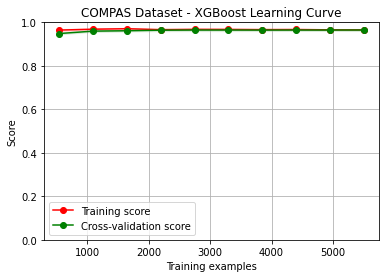

In [ ]:
# B: Learning Curve Function from scikit learn
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from matplotlib.pyplot import figure

compas_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# Define arguments
f1 = make_scorer(f1_score) 

df_compas_train_input = pd.get_dummies(df_compas_train_input)

# Plot actual learning curve
plot_learning_curve(estimator = compas_model, 
                    title = "COMPAS Dataset - XGBoost Learning Curve", 
                    X = df_compas_train_input, y = df_compas_train_label, 
                    cv = 5, 
                    scoring = f1, 
                    ylim = (0, 1), 
                    train_sizes = np.linspace(.1, 1.0, 10))

In [ ]:
min_metrics_line_chart(results_df_compas)

In [ ]:
maj_min_metrics_line_chart(results_df_compas) 

## 3) Homicide Dataset

### Data Import

In [ ]:
path_homicide = "/content/drive/My Drive/Master Thesis/Data/homicide_dataset.csv"
df_homicide_full = pd.read_csv(path_homicide, low_memory=False)

### Initial Data Preprocessing

In [ ]:
# Encoding Binary 
df_homicide_full["Perpetrator"] = df_homicide_full["Perpetrator Count"].apply(lambda val: False if val >= 1 else val == 0)

# Replace False by 1 and True by 0
df_homicide_full["Perpetrator"] = df_homicide_full["Perpetrator"].replace({False: 0, True: 1})

# Drop unnecessary columns
df_homicide_full = df_homicide_full.drop(['Record ID', "Perpetrator Count", "Victim Count"], axis=1)

# Replace values by NaNs
df_homicide_full.replace('Unknown', np.nan)

# Filter dataset based on year to reduce file size
df_homicide = df_homicide_full[df_homicide_full["Year"] > 2012]

**Dataframe Size Reduction Efforts**

In [ ]:
df_homicide.dtypes

In [ ]:
# Reduce the size of the numeric columns

df_homicide, NAlist = reduce_mem_usage(df_homicide)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

# Reduce the size of the string columns
df_homicide["Agency Code"]=df_homicide["Agency Code"].astype("category")
df_homicide["Agency Name"]=df_homicide["Agency Name"].astype("category")
df_homicide["Agency Type"]=df_homicide["Agency Type"].astype("category")
df_homicide["City"]=df_homicide["City"].astype("category")
df_homicide["State"]=df_homicide["State"].astype("category")
df_homicide["Month"]=df_homicide["Month"].astype("category")
df_homicide["Crime Type"]=df_homicide["Crime Type"].astype("category")
df_homicide["Crime Solved"]=df_homicide["Crime Solved"].astype("category")
df_homicide["Victim Sex"]=df_homicide["Victim Sex"].astype("category")
df_homicide["Perpetrator Age"]=df_homicide["Perpetrator Age"].astype("category")
df_homicide["Relationship"]=df_homicide["Relationship"].astype("category")
df_homicide["Weapon"]=df_homicide["Weapon"].astype("category")
df_homicide["Record Source"]=df_homicide["Record Source"].astype("category")

## Columns that a part of further preprocessing methods
df_homicide["Victim Race"]=df_homicide["Victim Race"].astype("category")
df_homicide["Victim Ethnicity"]=df_homicide["Victim Ethnicity"].astype("category")
df_homicide["Perpetrator Race"]=df_homicide["Perpetrator Race"].astype("category")
df_homicide["Perpetrator Sex"]=df_homicide["Perpetrator Sex"].astype("category")
df_homicide["Perpetrator Ethnicity"]=df_homicide["Perpetrator Ethnicity"].astype("category")

Memory usage of properties dataframe is : 5.04949951171875  MB
******************************
Column:  Year
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  Incident
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  Victim Age
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  Perpetrator
dtype before:  int64
dtype after:  uint8
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  4.363426208496094  MB
This is  86.41304347826087 % of the initial size
_________________

_________________

[]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:517: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:515: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [ ]:
# Check which columns are suitable for conversion in "category" data format
## We should stick to using the category type primarily for object columns where less than 50% of the values are unique.
df_homicide_copy = df_homicide.select_dtypes(include=['object']).copy()
df_homicide_copy.describe()

### Exploratory Data Analysis

In [ ]:
df_homicide.dtypes

In [ ]:
df_homicide.groupby(["Perpetrator"]).agg({"Perpetrator": 'count'})

In [ ]:
print(df_homicide.info)
print(df_homicide.describe)
print(df_homicide.columns)

In [ ]:
df_homicide.head(n=5)

In [ ]:
eda_descr_stats(data = df_homicide, disc_feature="Perpetrator Race", disc_min_value="Black", label = "Perpetrator")

### Data Analysis

#### 0) Preprocess data.

In [ ]:
# Execute preprocessing function
df_homicide_train_input, df_homicide_train_label = fair_preprocess(data = df_homicide,
                                                                   label = "Perpetrator",
                                                                   neg_class = 0,
                                                                   pos_class = 1)

# Check whether binary encoding was successful and seperate datasets were created
print(df_homicide.groupby(["Perpetrator"]).agg({"Perpetrator": 'count'}))
print(df_homicide_train_input.columns)

#### 1) Define Hyperparameters.

In [ ]:
df_homicide_train_input.dtypes

In [ ]:
# Create the hyperparameter grid
param_grid = {"learning_rate": [0.3],
                "n_estimators": [10, 50, 100],
                "max_depth": [3, 7], 
                "min_child_weight": [1, 4],       
                "reg_lambda": [1]}

xgb_grid_search = XGBClassifier(objective= 'binary:logistic', nthread=4)
cv=3

# Learning Curve for Slice 
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# Define model
f1 = make_scorer(f1_score)

# Dummy Coding
df_train_input_dummy = pd.get_dummies(df_homicide_train_input)

grid_rf_class = sklearn.model_selection.GridSearchCV(estimator = xgb_grid_search,
                                                      param_grid = param_grid, 
                                                      scoring= f1,
                                                      cv = cv,
                                                      refit = True,
                                                      return_train_score = False)
  
# Fit model
grid_rf_class.fit(df_train_input_dummy, df_homicide_train_label)

print(grid_rf_class.best_params_)
print(grid_rf_class.best_estimator_)

In [ ]:
best_classifier_homicide = hyperparameter_tuning(df_homicide_train_input, df_homicide_train_label)

#### 2) Create datasets with diff. minority group sizes.

In [ ]:
training_sizes_homicide = [5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350, 400, 450, 500, 600, 
                          700, 800, 900, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 
                          4000, 4250, 4500, 4750, 5000, 6000, 7000, 8000, 9000, 10000, 15000]

# Creating dfs for minority and majority group
is_black = df_homicide["Perpetrator Race"].isin(["Black"])
is_white = df_homicide["Perpetrator Race"].isin(["White"])
df_homicide_black = df_homicide[is_black]  # Minority
df_homicide_white = df_homicide[is_white]  # Majority

list_dfs_homicide = create_datasets(min_data = df_homicide_black, maj_data = df_homicide_white, training_sizes=training_sizes_homicide)

43
[9871, 9876, 9886, 9896, 9906, 9916, 9941, 9966, 9991, 10016, 10041, 10066, 10116, 10166, 10216, 10266, 10316, 10366, 10466, 10566, 10666, 10766, 10866, 11116, 11366, 11616, 11866, 12116, 12366, 12616, 12866, 13116, 13366, 13616, 13866, 14116, 14366, 14616, 14866, 15866, 16866, 17866, 18866]


#### 3) Create dataframes with diff. metrics.

In [ ]:
# Define arguments
label = "Perpetrator"
homicide_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                               colsample_bynode=1, colsample_bytree=1, gamma=0,
                               learning_rate=0.3, max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
                               nthread=4, objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                               silent=None, subsample=1, verbosity=1)
cv = 5 
discr_feature = "Perpetrator Race"
min_value = "Black"
maj_value = "White"

# Run function
results_df_homicide = metrics_to_df(list_dfs=list_dfs_homicide, label = label, model = homicide_model, 
                                  cv = cv, discr_feature = discr_feature, min_value = min_value,
                                  maj_value = maj_value)
results_df_homicide


,rows_complete,rows_minority,rows_majority,f1_complete,f1_complete_train,f1_minority,f1_majority,tpr_complete,tpr_minority,tpr_majority,fpr_minority,fpr_majority,prob_yhat_1_minority,prob_yhat_1_majority,rel_share_min_of_maj,aver_abs_odds_diff,stat_parity_diff,equal_opport_dist,disparate_impact
0,9871,5,9866,0.904307,0.904697,0.750000,0.904376,0.999755,1.000000,0.999754,1.000000,0.999419,1.000000,0.999696,0.000507,0.000413,0.000304,0.000246,1.000304
1,9876,10,9866,0.904046,0.904673,0.750000,0.904183,0.999264,1.000000,0.999263,1.000000,0.998838,1.000000,0.999189,0.001014,0.000949,0.000811,0.000737,1.000812
2,9886,20,9866,0.904295,0.904933,0.918919,0.904265,0.999632,1.000000,0.999632,1.000000,1.000000,1.000000,0.999696,0.002027,0.000184,0.000304,0.000368,1.000304
3,9896,30,9866,0.904330,0.904763,0.867925,0.904437,0.999878,1.000000,0.999877,1.000000,0.999419,1.000000,0.999797,0.003041,0.000352,0.000203,0.000123,1.000203
4,9906,40,9866,0.903961,0.904463,0.823529,0.904265,0.999633,1.000000,0.999632,1.000000,1.000000,1.000000,0.999696,0.004054,0.000184,0.000304,0.000368,1.000304
5,9916,50,9866,0.904428,0.904967,0.936170,0.904262,0.999023,1.000000,0.999018,1.000000,0.996514,1.000000,0.998581,0.005068,0.002234,0.001419,0.000982,1.001421
6,9941,75,9866,0.903667,0.904404,0.846154,0.904082,0.999268,1.000000,0.999263,1.000000,1.000000,1.000000,0.999392,0.007602,0.000368,0.000608,0.000737,1.000609
7,9966,100,9866,0.903559,0.904239,0.843931,0.904132,0.999270,1.000000,0.999263,1.000000,0.999419,1.000000,0.999290,0.010136,0.000659,0.000710,0.000737,1.000710
8,9991,125,9866,0.903764,0.904221,0.853211,0.904376,0.999757,1.000000,0.999754,1.000000,0.999419,1.000000,0.999696,0.012670,0.000413,0.000304,0.000246,1.000304
9,10016,150,9866,0.903738,0.903968,0.854962,0.904447,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.015204,0.000000,0.000000,0.000000,1.000000


In [ ]:
# Save metrics csv
results_df_homicide.to_csv("df_homicide_metrics.csv") 
from google.colab import files
files.download("df_homicide_metrics.csv")

#### 4) Create visualizations.

In [ ]:
# Get Feature Importance
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

homicide_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                               colsample_bynode=1, colsample_bytree=1, gamma=0,
                               learning_rate=0.3, max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
                               nthread=4, objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                               silent=None, subsample=1, verbosity=1)

homicide_model.fit(df_homicide_train_input, df_homicide_train_label)
plot_importance(homicide_model)
pyplot.show()

In [ ]:
# B: Learning Curve Function from scikit learn
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from matplotlib.pyplot import figure

# Define arguments
f1 = make_scorer(f1_score) 

df_homicide_train_input = pd.get_dummies(df_homicide_train_input)

# Plot actual learning curve
plot_learning_curve(estimator = model, 
                    title = "Adult Dataset - Random Forest Learning Curve", 
                    X = df_homicide_train_input, y = df_homicide_train_label, 
                    cv = 5, 
                    scoring = f1, 
                    ylim = (0, 1), 
                    train_sizes = np.linspace(.1, 1.0, 10))

In [ ]:
min_metrics_line_chart(results_df_homicide)

In [ ]:
maj_min_metrics_line_chart(results_df_homicide) 

## 4) German Credit Dataset

The German Credit dataset contains 1000 credit records containing attributes such as personal status and sex, credit score, credit amount, housing status etc. It can be used in studies about gender inequalities on credit-related issues [42].



### Data Import

In [ ]:
# DATA IMPORT - Long dataset version
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# path_credit_uci = "/content/drive/My Drive/Master Thesis/Data/german_credit_dataset.csv"

# Set the path to the CSV containing the dataset to train on.
path_credit_uci = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
column_names_credit = ["chk_acct", "duration", "credit_his", "purpose", "amount", "saving_acct", 
                       "present_emp", "installment_rate", "sex", "other_debtor", "present_resid", 
                       "property", "age", "other_install", "housing", "n_credits", "job", "n_people", 
                       "telephone", "foreign", "response"]

# Read the dataset from the provided CSV and print out information about it.
df_credit_long = pd.read_csv(path_credit_uci, delim_whitespace=True, names = column_names_credit)

In [ ]:
# DATA IMPORT - Short dataset version
path_credit = "/content/drive/My Drive/Master Thesis/Data/german_credit_dataset.csv"
df_credit_short = pd.read_csv(path_credit, header = 0, sep = ";")

In [ ]:
# Join Risk and Sex column of the short dataset to rest of columns of the long dataset
df_credit_long['id'] = range(0, len(df_credit_long))

# Join based on "id" column - add risk and Sex column from short dataset to long dataset
df_credit_short_reduced_cols = df_credit_short.loc[:, ["id", "Sex", "Risk"]]
df_credit = pd.merge(df_credit_long, df_credit_short_reduced_cols, how = "left", on = "id")
df_credit

### Initial Data Preprocessing

In [ ]:
# Drop unnecessary columns
df_credit = df_credit.drop(['id', "response"], axis=1)

df_credit["Risk"] = df_credit["Risk"].replace({'good': 1, 'bad': 0})

df_credit.rename(columns={'sex':'sex_specific'})

### Exploratory Data Analysis

In [ ]:
print(df_credit.info)
print(df_credit.describe())
print(df_credit.columns)

In [ ]:
print(df_credit)
print(df_credit.groupby(["Risk"]).agg({"Risk": 'count'}))

Exploratory Data Analysis

In [ ]:
eda_descr_stats(df_credit, disc_feature="Sex", disc_min_value="female", label ="Risk")

### Data Analysis

#### 0) Preprocess data.

In [ ]:
# Execute preprocessing function
df_credit_train_input, df_credit_train_label = fair_preprocess(data = df_credit, 
                                                               label = "Risk",
                                                               neg_class = 0,
                                                               pos_class = 1)

# Check whether binary encoding was successful and seperate datasets were created
print(df_credit.groupby(["Risk"]).agg({"Risk": 'count'}))
print(df_credit_train_input.columns)

#### 1) Define Hyperparameters.

In [ ]:
# Create the hyperparameter grid
param_grid = {"learning_rate": [0.2],
              "n_estimators": [10, 20, 30, 40, 50],
              "max_depth": [6, 9, 12], 
              "min_child_weight": [0.5, 1, 3, 5],   
              "reg_lambda": [1, 1.2]}
xgb_grid_search = XGBClassifier(objective= 'binary:logistic', nthread=4)
cv=5
# Learning Curve for Slice 
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
# Define model
f1 = make_scorer(f1_score)

# Dummy Coding
df_train_input_dummy = pd.get_dummies(df_credit_train_input)

grid_rf_class = sklearn.model_selection.GridSearchCV(estimator = xgb_grid_search,
                                                     param_grid = param_grid, 
                                                     scoring= f1,
                                                     cv = cv,
                                                     refit = True,
                                                     return_train_score = False)
  
# Fit model
grid_rf_class.fit(df_train_input_dummy, df_credit_train_label)

print(grid_rf_class.best_params_)
print(grid_rf_class.best_estimator_)

{'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 30, 'reg_lambda': 1}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=30, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


#### 2) Create datasets with diff. minority group sizes.

In [ ]:
training_sizes = [5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350, 400, 450, 500, 600, 
                  700, 800, 900, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 
                  4000, 4250, 4500, 4750, 5000, 6000, 7000, 8000, 9000, 10000, 15000]

# Creating dfs for minority and majority group
is_unpriv = df_credit["Sex"].isin(["female"])
is_priv = df_credit["Sex"].isin(["male"])
df_credit_unpriv = df_credit[is_unpriv]  # Minority
df_credit_priv = df_credit[is_priv]  # Majority

list_dfs_credit = create_datasets(min_data = df_credit_unpriv, maj_data = df_credit_priv, training_sizes=training_sizes)

14
[695, 700, 710, 720, 730, 740, 765, 790, 815, 840, 865, 890, 940, 990]


#### 3) Create dataframes with diff. metrics.

In [ ]:
list_dfs = list_dfs_credit
label = "Risk"
credit_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                             colsample_bynode=1, colsample_bytree=1, gamma=0,
                             learning_rate=0.2, max_delta_step=0, max_depth=9,
                             min_child_weight=1, missing=None, n_estimators=30, n_jobs=1,
                             nthread=4, objective='binary:logistic', random_state=0,
                             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                             silent=None, subsample=1, verbosity=1)
cv = 5
discr_feature = "Sex"
min_value = "female"
maj_value = "male"

results_df_credit = metrics_to_df(list_dfs=list_dfs_credit, label = label, model = credit_model, 
                                  cv = cv, discr_feature = discr_feature, min_value = min_value,
                                  maj_value = maj_value)

results_df_credit

,rows_complete,rows_minority,rows_majority,f1_complete,f1_complete_train,f1_minority,f1_majority,tpr_complete,tpr_minority,tpr_majority,fpr_minority,fpr_majority,prob_yhat_1_minority,prob_yhat_1_majority,rel_share_min_of_maj,aver_abs_odds_diff,stat_parity_diff,equal_opport_dist,disparate_impact
0,695,5,690,0.832861,0.999255,0.888889,0.832381,0.876740,1.000000,0.875752,1.000000,0.596859,1.000000,0.798551,0.007246,0.263695,0.201449,0.124248,1.252269
1,700,10,690,0.848256,0.999013,0.857143,0.848138,0.889328,0.857143,0.889780,0.333333,0.544503,0.700000,0.794203,0.014493,0.121903,-0.094203,-0.032637,0.881387
2,710,20,690,0.842686,0.999270,0.827586,0.843100,0.892788,0.857143,0.893788,0.500000,0.591623,0.750000,0.810145,0.028986,0.064134,-0.060145,-0.036645,0.925760
3,720,30,690,0.831025,0.999270,0.684211,0.836364,0.877193,0.928571,0.875752,0.687500,0.570681,0.800000,0.791304,0.043478,0.084820,0.008696,0.052820,1.010989
4,730,40,690,0.843155,0.998812,0.754717,0.847619,0.885714,0.769231,0.891784,0.500000,0.554974,0.675000,0.798551,0.057971,0.088763,-0.123551,-0.122553,0.845281
5,740,50,690,0.848057,0.999534,0.846154,0.848197,0.895522,0.891892,0.895792,0.615385,0.565445,0.820000,0.804348,0.072464,0.026920,0.015652,-0.003900,1.019459
6,765,75,690,0.842105,0.999091,0.810811,0.845420,0.888889,0.900000,0.887776,0.640000,0.554974,0.813333,0.795652,0.108696,0.048625,0.017681,0.012224,1.022222
7,790,100,690,0.843252,0.999128,0.813793,0.847328,0.879371,0.808219,0.889780,0.481481,0.549738,0.720000,0.795652,0.144928,0.074909,-0.075652,-0.081560,0.904918
8,815,125,690,0.828383,0.999566,0.759036,0.839388,0.871528,0.818182,0.879760,0.541667,0.565445,0.712000,0.792754,0.181159,0.042678,-0.080754,-0.061578,0.898135
9,840,150,690,0.831210,0.998960,0.757282,0.845714,0.870000,0.772277,0.889780,0.551020,0.560209,0.700000,0.798551,0.217391,0.063346,-0.098551,-0.117502,0.876588


In [ ]:
# Save metrics csv
results_df_credit.to_csv("df_credit_metrics.csv") 
from google.colab import files
files.download("df_credit_metrics.csv")

#### 4) Create visualizations.

In [ ]:
# Get Feature Importance
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

credit_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1.2, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
credit_model.fit(df_credit_train_input, df_credit_train_label)
plot_importance(credit_model)
pyplot.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

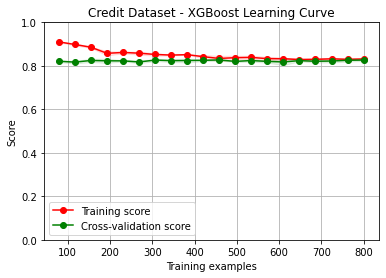

In [ ]:
# B: Learning Curve Function from scikit learn
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from matplotlib.pyplot import figure

# Define arguments
f1 = make_scorer(f1_score) 

df_credit_train_input = pd.get_dummies(df_credit_train_input)


# Plot actual learning curve
plot_learning_curve(estimator = credit_model, 
                    title = "Credit Dataset - XGBoost Learning Curve", 
                    X = df_credit_train_input, y = df_credit_train_label, 
                    cv = 5, 
                    scoring = f1, 
                    ylim = (0, 1), 
                    train_sizes = np.linspace(.1, 1.0, 20))

In [ ]:
min_metrics_line_chart(results_df_credit, title = "Minority Metrics for the Adult Dataset with XGBoost")

In [ ]:
maj_min_metrics_line_chart(results_df_credit, title = "Majority and Minority Metrics for the Adult Dataset with XGBoost")

## 5) Home Credit Default Risk

https://www.kaggle.com/c/home-credit-default-risk/overview

### Data Import

In [3]:
path = "/content/drive/My Drive/Master Thesis/Data/application_train.csv"
df_application = pd.read_csv(path)

In [ ]:
df_application

In [ ]:
df_application.columns

### Initial Data Preprocessing

In [4]:
df_application = df_application.drop(["SK_ID_CURR"], axis=1)

# 1 should be positive (= good consequence, predict to repay load), 0 should be negative (= bad consequence, predict not to repay the loan)
df_application["TARGET"] = df_application["TARGET"].replace({1: "no_repay", 0: "repay"})
df_application["TARGET"] = df_application["TARGET"].replace({"no_repay": 0, "repay": 1})

# Replace XNA for CODE_GENDER by NaN
df_application["CODE_GENDER"].replace('XNA', np.nan)

0         M
1         F
2         M
3         F
4         M
         ..
307506    M
307507    F
307508    F
307509    F
307510    F
Name: CODE_GENDER, Length: 307511, dtype: object

In [ ]:
# Check whether binary encoding was successful and seperate datasets were created
print(df_application.groupby(["TARGET"]).agg({"TARGET": 'count'}))

**Dataframe Size Reduction Efforts**

In [ ]:
df_application.dtypes

In [5]:
# Check which columns are suitable for conversion in "category" data format
## We should stick to using the category type primarily for object columns where less than 50% of the values are unique.
df_application_copy = df_application.select_dtypes(include=['object']).copy()
df_application_copy.describe()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


In [ ]:
# Reduce the size of the numeric columns

df_application, NAlist = reduce_mem_usage(df_application)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

In [ ]:
df_application.select_dtypes(include=['object']).columns

In [7]:
for col in ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
            'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
            'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
            'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
            'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']:
    df_application[col] = df_application[col].astype('category')

### Exploratory Data Analysis

1. Sensitive Attribute: One or more of the following features are sensitive ones: Index(['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=121).
1. Sensitive Attribute: These are the individual values for the sensitive attribute: [M, F, XNA]
Categories (3, object): [M, F, XNA].
2. Binary Target Variable: The Binary Target Feature has the following values and counts:
        TARGET
TARGET        
0        24825
1       282686
3. The Total Number of Predictor Features is: 121.
4. The Total Number of Training Examples is: 307511.
5. T

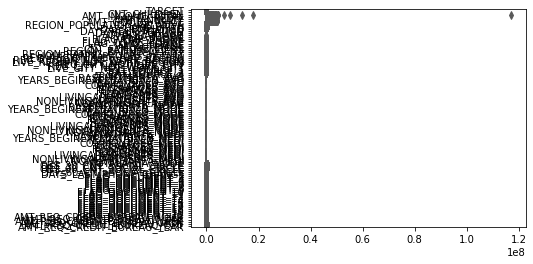

In [8]:
eda_descr_stats(df_application, disc_feature= "CODE_GENDER", disc_min_value="F", label="TARGET")

### Data Analysis

#### 0) Preprocess data.

In [ ]:
# Execute preprocessing function
df_application_train_input, df_application_train_label = fair_preprocess(data = df_application, 
                                                                        label = "TARGET", 
                                                                        neg_class = 0, 
                                                                        pos_class = 1)

#### 1) Define Hyperparameters.

In [ ]:
# Create the hyperparameter grid
param_grid = {"learning_rate": [0.3],
                "n_estimators": [60],
                "max_depth": [3], 
                "min_child_weight": [4],       
                "reg_lambda": [1, 1.2, 1.4]}
xgb_grid_search = XGBClassifier(objective= 'binary:logistic', nthread=4)
cv=3
# Learning Curve for Slice 
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
# Define model
f1 = make_scorer(f1_score)

# Dummy Coding
df_train_input_dummy = pd.get_dummies(df_application_train_input)

grid_rf_class = sklearn.model_selection.GridSearchCV(estimator = xgb_grid_search,
                                                     param_grid = param_grid, 
                                                     scoring= f1,
                                                     cv = cv,
                                                     refit = True,
                                                     return_train_score = False)
  
# Fit model
grid_rf_class.fit(df_train_input_dummy, df_application_train_label)

print(grid_rf_class.best_params_)
print(grid_rf_class.best_estimator_)

{'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 60, 'reg_lambda': 1}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=4, missing=None, n_estimators=60, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


#### 2) Create datasets with diff. minority group sizes.

In [ ]:
training_sizes = [5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350, 400, 450, 500, 600, 
                  700, 800, 900, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 
                  4000, 4250, 4500, 4750, 5000, 6000, 7000, 8000, 9000, 10000, 15000]

# Creating dfs for minority and majority group
is_unpriv = df_application["CODE_GENDER"].isin(["F"])
is_priv = df_application["CODE_GENDER"].isin(["M"])
df_application_unpriv = df_application[is_unpriv]  # Minority
df_application_priv = df_application[is_priv]  # Majority

list_dfs_application = create_datasets(min_data = df_application_unpriv, maj_data = df_application_priv, training_sizes=training_sizes)

45
[105064, 105069, 105079, 105089, 105099, 105109, 105134, 105159, 105184, 105209, 105234, 105259, 105309, 105359, 105409, 105459, 105509, 105559, 105659, 105759, 105859, 105959, 106059, 106309, 106559, 106809, 107059, 107309, 107559, 107809, 108059, 108309, 108559, 108809, 109059, 109309, 109559, 109809, 110059, 111059, 112059, 113059, 114059, 115059, 120059]


#### 3) Create dataframes with diff. metrics.

In [ ]:
list_dfs = list_dfs_application
label = "TARGET"
cv = 5 
discr_feature = "CODE_GENDER"
min_value = "F"
maj_value = "M"
application_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                                  colsample_bynode=1, colsample_bytree=1, gamma=0,
                                  learning_rate=0.3, max_delta_step=0, max_depth=3,
                                  min_child_weight=4, missing=None, n_estimators=60, n_jobs=1,
                                  nthread=4, objective='binary:logistic', random_state=0,
                                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                                  silent=None, subsample=1, verbosity=1)


results_df_application = metrics_to_df(list_dfs=list_dfs, label = label, model = application_model, 
                                  cv = cv, discr_feature = discr_feature, min_value = min_value,
                                  maj_value = maj_value)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:219: RuntimeWarning:

invalid value encountered in long_scalars



In [ ]:
results_df_application

In [ ]:
# Save metrics csv
results_df_application.to_csv("df_application_metrics.csv") 
from google.colab import files
files.download("df_application_metrics.csv")

#### 4) Create visualizations.

In [ ]:
# B: Learning Curve Function from scikit learn
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from matplotlib.pyplot import figure

# Define arguments
f1 = make_scorer(f1_score) 

df_application_train_input = pd.get_dummies(df_application_train_input)

# Plot actual learning curve
plot_learning_curve(estimator = model, 
                    title = "Adult Dataset - Random Forest Learning Curve", 
                    X = df_application_train_input, y = df_application_train_label, 
                    cv = 5, 
                    scoring = f1, 
                    ylim = (0, 1), 
                    train_sizes = np.linspace(.1, 1.0, 10))

In [ ]:
min_metrics_line_chart(results_df_application)

In [ ]:
maj_min_metrics_line_chart(results_df_application) 

# Generalizable Rule 

**Approach**:
1. Rename columns of each metrics_df to a format in which the name of the original dataset is stored. 
2. Merge data frames with metrics (column bind) on minority row index via left join. Start with the dataframe with the most rows_minority and then merge step by step with the df with second most, etc.
3. Determine slop change per row in comparison to previous row. 
4. Then plot only relevant fairness metrics. 
5. For each inflection point (slope change < threshold) for each dataset and metric of the chosen subset, plot a line that vertically touches then the x-axis (-> https://plotly.com/python/shapes/).
6. Then, create corridor shape (dotted, medium alpha) that covers inflection point with the minimum number of training examples and the maximum and everything in between (-> https://plotly.com/python/shapes/ - *Highlighting Time Series Regions with Rectangle Shapes*).





In [ ]:
# 1. Rename columns of each results_df

# results_df_adult
results_df_adult.columns = [str(col) + '_adult' for col in results_df_adult.columns]
# Rename rows_minority_adult column into standard format
results_df_adult = results_df_adult.rename(index=str, 
                                           columns={"rows_minority_adult":"rows_minority"})

# results_df_compas
results_df_compas.columns = [str(col) + '_compas' for col in results_df_compas.columns]
# Rename rows_minority_compas column into standard format
results_df_adult = results_df_adult.rename(index=str, 
                                           columns={"rows_minority_compas":"rows_minority"})

# results_df_homicide
results_df_homicide.columns = [str(col) + '_homicide' for col in results_df_homicide.columns]
# Rename rows_minority_homicide column into standard format
results_df_adult = results_df_adult.rename(index=str, 
                                           columns={"rows_minority_homicide":"rows_minority"})

# results_df_credit
results_df_credit.columns = [str(col) + '_credit' for col in results_df_credit.columns]
# Rename rows_minority_credit column into standard format
results_df_adult = results_df_adult.rename(index=str, 
                                           columns={"rows_minority_credit":"rows_minority"})

In [ ]:
# 2. Left join all result dfs into one
merge_1 = pd.merge(data1, data2, 
                   how='left', on='X1')

merge_2 = pd.merge(data1, data2, 
                   how='left', on='X1')

complete_results_df = pd.merge(data1, data2, 
                               how='left', on='X1')

Determine slop change per row in comparison to previous row: 
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html


**Ideas:**
- Get diff for rows_minority and the metric of interest

In [ ]:
# 3. Determine slope change 

# Calculate slope (rise(y-axis change)/run(x-axis change))

# Run
complete_results_df["rows_minority_diff"] = complete_results_df["rows_minority"].diff()

# Rise
# Calculate slopes for aver_abs_odds_diff
complete_results_df["aver_abs_odds_diff_adult_diff"] = complete_results_df["aver_abs_odds_diff_adult"].diff()
complete_results_df["aver_abs_odds_diff_adult_slope"] = complete_results_df["aver_abs_odds_diff_adult_diff"] / complete_results_df["rows_minority_diff"]
complete_results_df["aver_abs_odds_diff_compas_diff"] = complete_results_df["aver_abs_odds_diff_compas"].diff()
complete_results_df["aver_abs_odds_diff_compas_slope"] = complete_results_df["aver_abs_odds_diff_compas_diff"] / complete_results_df["rows_minority_diff"]
complete_results_df["aver_abs_odds_diff_homicide_diff"] = complete_results_df["aver_abs_odds_diff_homicide"].diff()
complete_results_df["aver_abs_odds_diff_homicide_slope"] = complete_results_df["aver_abs_odds_diff_homicide_diff"] / complete_results_df["rows_minority_diff"]
complete_results_df["aver_abs_odds_diff_credit_diff"] = complete_results_df["aver_abs_odds_diff_credit"].diff()
complete_results_df["aver_abs_odds_diff_credit_slope"] = complete_results_df["aver_abs_odds_diff_credit_diff"] / complete_results_df["rows_minority_diff"]

# Calculate slopes for stat_parity_diff
complete_results_df["stat_parity_diff_adult_diff"] = complete_results_df["stat_parity_diff_adult"].diff()
complete_results_df["stat_parity_diff_adult_slope"] = complete_results_df["stat_parity_diff_adult_diff"] / complete_results_df["rows_minority_diff"]
complete_results_df["stat_parity_diff_compas_diff"] = complete_results_df["stat_parity_diff_compas"].diff()
complete_results_df["stat_parity_diff_compas_slope"] = complete_results_df["stat_parity_diff_compas_diff"] / complete_results_df["rows_minority_diff"]
complete_results_df["stat_parity_diff_homicide_diff"] = complete_results_df["stat_parity_diff_homicide"].diff()
complete_results_df["stat_parity_diff_homicide_slope"] = complete_results_df["stat_parity_diff_homicide_diff"] / complete_results_df["rows_minority_diff"]
complete_results_df["stat_parity_diff_credit_diff"] = complete_results_df["stat_parity_diff_credit"].diff()
complete_results_df["stat_parity_diff_credit_slope"] = complete_results_df["stat_parity_diff_credit_diff"] / complete_results_df["rows_minority_diff"]

# Calculate slopes for equal_opport_dist
complete_results_df["equal_opport_dist_adult_diff"] = complete_results_df["equal_opport_dist_adult"].diff()
complete_results_df["equal_opport_dist_adult_slope"] = complete_results_df["equal_opport_dist_adult_diff"] / complete_results_df["rows_minority_diff"]
complete_results_df["equal_opport_dist_compas_diff"] = complete_results_df["equal_opport_dist_compas"].diff()
complete_results_df["equal_opport_dist_compas_slope"] = complete_results_df["equal_opport_dist_compas_diff"] / complete_results_df["rows_minority_diff"]
complete_results_df["equal_opport_dist_homicide_diff"] = complete_results_df["equal_opport_dist_homicide"].diff()
complete_results_df["equal_opport_dist_homicide_slope"] = complete_results_df["equal_opport_dist_homicide_diff"] / complete_results_df["rows_minority_diff"]
complete_results_df["equal_opport_dist_credit_diff"] = complete_results_df["equal_opport_dist_credit"].diff()
complete_results_df["equal_opport_dist_credit_slope"] = complete_results_df["equal_opport_dist_credit_diff"] / complete_results_df["rows_minority_diff"]

# Calculate slopes for disparate_impact
complete_results_df["disparate_impact_adult_diff"] = complete_results_df["disparate_impact_adult"].diff()
complete_results_df["disparate_impact_adult_slope"] = complete_results_df["disparate_impact_adult_diff"] / complete_results_df["rows_minority_diff"]
complete_results_df["disparate_impact_compas_diff"] = complete_results_df["disparate_impact_compas"].diff()
complete_results_df["disparate_impact_compas_slope"] = complete_results_df["disparate_impact_compas_diff"] / complete_results_df["rows_minority_diff"]
complete_results_df["disparate_impact_homicide_diff"] = complete_results_df["disparate_impact_homicide"].diff()
complete_results_df["disparate_impact_homicide_slope"] = complete_results_df["disparate_impact_homicide_diff"] / complete_results_df["rows_minority_diff"]
complete_results_df["disparate_impact_credit_diff"] = complete_results_df["disparate_impact_credit"].diff()
complete_results_df["disparate_impact_credit_slope"] = complete_results_df["disparate_impact_credit_diff"] / complete_results_df["rows_minority_diff"]

In [ ]:
complete_results_df

In [ ]:
# 4. Plot all fairness metrics 

  import plotly.graph_objects as go

  # Create traces

  # Performance Metrics
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=complete_results_df["rows_complete"], y=complete_results_df["f1_majority"],
                      mode='lines+markers',
                      name='F1 Majority'))
  fig.add_trace(go.Scatter(x=complete_results_df["rows_complete"], y=complete_results_df["f1_minority"],
                      mode='lines+markers',
                      name='F1 Minority'))
  # TPR
  fig.add_trace(go.Scatter(x=complete_results_df["rows_complete"], y=complete_results_df["tpr_majority"],
                      mode='lines+markers',
                      name='TPR/Recall Majority'))
  fig.add_trace(go.Scatter(x=complete_results_df["rows_complete"], y=complete_results_df["tpr_minority"],
                      mode='lines+markers',
                      name='TPR/Recall Minority'))
  # FPR
  fig.add_trace(go.Scatter(x=complete_results_df["rows_complete"], y=complete_results_df["fpr_majority"],
                      mode='lines+markers',
                      name='FPR Majority'))
  fig.add_trace(go.Scatter(x=complete_results_df["rows_complete"], y=complete_results_df["fpr_minority"],
                      mode='lines+markers',
                      name='FPR Minority'))

  # Edit the layout
  fig.update_layout(title={'text': title,
                           'y':0.9,
                           'x':0.5,
                           # 'xanchor': 'center',
                           'yanchor': 'top'},
                    xaxis_title='Rows Complete',
                    yaxis_title='Metric Score', 
                    font=dict(size=14))
  
  fig.show()

5. For each inflection point (slope change < threshold) for each dataset and metric of the chosen subset, plot a line that vertically touches then the x-axis (-> https://plotly.com/python/shapes/).

In [ ]:
# Add shapes
fig.add_shape(
        # Line Vertical
        dict(
            type="line",
            x0=1,
            y0=0,
            x1=1,
            y1=2,
            line=dict(
                color="RoyalBlue",
                width=3, 
                dash="dot",
                opacity=0.7
            )

fig.add_shape(
        # Line reference to the axes
            type="line",
            xref="x",
            yref="y",
            x0=4,
            y0=0,
            x1=8,
            y1=1,
            line=dict(
                color="LightSeaGreen",
                width=3,
            ),
        )

6. Then, create corridor shape (dotted, medium alpha) that covers inflection point with the minimum number of training examples and the maximum and everything in between (-> https://plotly.com/python/shapes/ - *Highlighting Time Series Regions with Rectangle Shapes*).

In [ ]:
fig = go.Figure()

# Add shape regions
fig.update_layout(
    shapes=[
        # 1st highlight during Feb 4 - Feb 6
        dict(
            type="rect",
            # x-reference is assigned to the x-values
            xref="x",
            # y-reference is assigned to the plot paper [0,1]
            yref="paper",
            x0="2015-02-04", # First value of corridor
            y0=0,
            x1="2015-02-06", # Second value of corridor 
            y1=1,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    ]
)

fig.show()

# Other Datasets

## Communities and Crime Dataset

The Communities and Crime dataset gathers information from different communities in the United States related to several factors that can highly influence some common crimes such as robberies, murders or rapes. The data includes crime data obtained from the 1990 US LEMAS survey and the 1995 FBI Unified Crime Report. It also contains socio-economic data from the 1990 US Census.

### Data Import

In [ ]:
path_communities = "/content/drive/My Drive/Master Thesis/Data/communities_and_crime_dataset.csv"
df_communities = pd.read_csv(path_communities, encoding = "utf-8")
df_communities

,communityname,state,countyCode,communityCode,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumKidsBornNeverMar,PctKidsBornNeverMar,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,OwnOccQrange,RentLowQ,RentMedian,RentHighQ,RentQrange,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,murders,murdPerPop,rapes,rapesPerPop,robberies,robbbPerPop,assaults,assaultPerPop,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39,5320,1,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.00,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,28.82,5.49,50.73,3.67,26.38,5.22,4.47,3.22,91.43,90.17,95.78,95.81,44.56,58.88,31,0.36,1277,8.69,13.00,20.99,30.93,0.93,1.39,2.24,3.30,85.68,1.37,4.81,4.17,2.99,3.00,2.84,91.46,0.39,11.06,3,64,98.37,91.01,3.12,37.50,1959,0.00,0.28,215900,262600,326900,111000,685,1001,1001,316,1001,23.8,21.1,14.0,11,0,10.66,53.72,65.29,78.09,89.14,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,6.5,1845.9,9.63,?,?,?,?,0.0,?,0,0.00,0,0,1,8.2,4,32.81,14,114.85,138,1132.08,16,131.26,2,16.41,41.02,1394.59
1,Marpletownship,PA,45,47616,1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.00,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,29.28,6.39,37.64,4.23,27.99,6.45,5.42,3.11,86.91,85.33,96.82,86.46,51.14,62.43,43,0.24,1920,5.21,8.65,13.33,22.50,0.43,0.72,1.11,1.87,87.79,1.81,4.25,3.34,2.70,2.83,1.96,89.03,1.01,23.60,3,240,97.15,84.88,0.00,18.33,1958,0.31,0.14,136300,164200,199900,63600,467,560,672,205,627,27.6,20.7,12.5,0,0,8.30,77.17,71.27,90.22,96.12,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,10.6,2186.7,3.84,?,?,?,?,0.0,?,0,0.00,1,4.25,5,21.26,24,102.05,57,242.37,376,1598.78,26,110.55,1,4.25,127.56,1955.95
2,Tigardcity,OR,?,?,1,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.00,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,21.52,8.79,32.48,10.10,25.78,14.76,12.55,2.95,78.54,78.85,92.37,75.72,66.08,74.19,164,0.88,1468,16.42,23.98,32.08,35.63,0.82,1.20,1.61,1.78,93.11,1.14,2.97,2.05,2.42,2.69,2.06,64.18,2.03,47.46,3,544,95.68,57.79,0.92,7.54,1976,1.55,0.12,74700,90400,112000,37300,370,428,520,150,484,24.1,21.7,11.6,16,0,5.00,44.77,36.60,61.26,82.85,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,10.6,2780.9,4.

### Initial Data Preprocessing

Drop Columns

Replace values with NaNs

### Exploratory Data Analysis

In [ ]:
print(df_communities.info)
print(df_communities.describe())
print(df_communities.columns)

In [ ]:
label = "Risk" # 1 = "Good"; 0 = "Bad"

eda_descr_stats(df_communities, disc_feature="Sex", disc_min_value="female", label = "Risk")

### Data Analysis

#### 0) Preprocess data.

In [ ]:
# Execute preprocessing function
df_3_adult_train_input, df_3_adult_train_label = fair_preprocess(data = df_3_adult, 
                                                                 label = "Over-50K", 
                                                                 neg_class = "<=50K", 
                                                                 pos_class = ">50K")

# Check whether binary encoding was successful and seperate datasets were created
print(df_3_adult.groupby(["Over-50K"]).agg({"Over-50K": 'count'}))
print(df_3_adult_train_input.columns)

#### 1) Define Hyperparameters.

In [ ]:
best_classifier_compas = hyperparameter_tuning(df_compas_train_input, df_compas_train_label)

#### 2) Create datasets with diff. minority group sizes.

In [ ]:
training_sizes = [5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350, 400, 450, 500, 600, 
                  700, 800, 900, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 
                  4000, 4250, 4500, 4750, 5000, 6000, 7000, 8000, 9000, 10000, 15000]

# Creating dfs for minority and majority group
is_black = df_compas["race"].isin(["African-American"])
is_white = df_compas["race"].isin(["Caucasian"])
df_compas_black = df_compas[is_black]  # Minority
df_compas_white = df_compas[is_white]  # Majority

list_dfs_compas = create_datasets(min_data = df_compas_black, maj_data = df_compas_white, training_sizes=training_sizes)

#### 3) Create dataframes with diff. metrics.

In [ ]:
list_dfs = list_dfs_compas
label = "two_year_recid"
model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                              criterion='gini', max_depth=25, max_features='auto',
                              max_leaf_nodes=None, max_samples=None,
                              min_impurity_decrease=0.0, min_impurity_split=None,
                              min_samples_leaf=1, min_samples_split=5,
                              min_weight_fraction_leaf=0.0, n_estimators=100,
                              n_jobs=None, oob_score=False, random_state=None,
                              verbose=0, warm_start=False)

# model = grid_rf_class # <- Best model from hyperparameter tuning

cv = 5 # To Do: For final calculations, change to cv = 10
discr_feature = "race"
min_value = "African-American"
maj_value = "Caucasian"

results_df_compas = metrics_to_df(list_dfs=list_dfs_compas, label = label, model = model, 
                                  cv = cv, discr_feature = "race", min_value = min_value,
                                  maj_value = maj_value)

#### 4) Create visualizations.

In [ ]:
# B: Learning Curve Function from scikit learn
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from matplotlib.pyplot import figure

# Define arguments
f1 = make_scorer(f1_score) 

df_3_adult_train_input = pd.get_dummies(df_3_adult_train_input)

# Plot actual learning curve
plot_learning_curve(estimator = model, 
                    title = "Communities and Crime Dataset - Random Forest Learning Curve", 
                    X = df_3_adult_train_input, y = df_3_adult_train_label, 
                    cv = 5, 
                    scoring = f1, 
                    ylim = (0, 1), 
                    train_sizes = np.linspace(.1, 1.0, 10))

In [ ]:
min_metrics_line_chart(results_df_compas)

In [ ]:
maj_min_metrics_line_chart(results_df_compas) 

Ideas
- Individual Metric dfs zusammenmergen
- Rows Minority als key dafür nehmen
- Auf Kernmetriken fokussieren, diese dann umbenennen
- Kernmetriken von verschiedenen Datasets in zentralem Line Chart zeigen
- Dann Korridor einzeichnen, wo die Knickpunkte sich jeweils befinden
- Überlappungen von Korridoren zeigen, indem sich durch alpha die Farbe gegenseitig verstärkt
- Dann Tabelle rechts daneben platzieren, die Zusatzinformationen bietet

# Deprecated

In [ ]:
# Random Forest Hyperparameter Tuning Results

# model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
#                               criterion='gini', max_depth=25, max_features='auto',
#                               max_leaf_nodes=None, max_samples=None,
#                               min_impurity_decrease=0.0, min_impurity_split=None,
#                               min_samples_leaf=1, min_samples_split=5,
#                               min_weight_fraction_leaf=0.0, n_estimators=100,
#                               n_jobs=None, oob_score=False, random_state=None,
#                               verbose=0, warm_start=False)

In [ ]:
# RF Hyperparameter Tuning

# HYPERPARAMETER TUNING

def hyperparameter_tuning(df_train_input, df_train_label):

  from sklearn import model_selection

  # Create the hyperparameter grid
  # Important: Keys in the dictionary must be valid hyperparameters 
  param_grid = {"learning_rate": [0.3, 0.1],
                "max_depth": [3, 6, 9], 
                "min_child_weight": [1, 3, 5],       
                "reg_lambda": [2, 5, 10, 15, 100]}

  # 1. Fundamental hyperparameters
  # learning rate & number of trees

  xgb1 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5,
                     min_child_weight=1, gamma=0, subsample=0.8,
                     colsample_bytree=0.8, objective= 'binary:logistic', 
                     scale_pos_weight=1, seed=27)


  # n_estimators = number of trees in the foreset
  # max_features = max number of features considered for splitting a node
  # max_depth = max number of levels in each decision tree
  # min_samples_split = min number of data points placed in a node before the node is split
  # min_samples_leaf = min number of data points allowed in a leaf node
  # bootstrap = method for sampling data points (with or without replacement)

  # Define classifier
  rf_grid_search = RandomForestClassifier(criterion= "gini",
                                          max_features = "auto")

  # Learning Curve for Slice 
  from sklearn.metrics import make_scorer
  from sklearn.metrics import f1_score

  # Define model
  f1 = make_scorer(f1_score)

  # Dummy Coding
  df_train_input_dummy = pd.get_dummies(df_train_input)

  grid_rf_class = sklearn.model_selection.GridSearchCV(estimator = rf_grid_search,
                                                      param_grid = param_grid, 
                                                      scoring= f1,
                                                      n_jobs = 2, 
                                                      cv = 5,
                                                      refit = True,
                                                      return_train_score = True)
  
  # Fit model
  grid_rf_class.fit(df_train_input_dummy, df_train_label)

  return(grid_rf_class)

**Steps**
1. Specify hyperparameters for the chosen classification algorithm by means of grid search using standard ranges. Specify by means of on the dataset as a whole (full min. and maj.).
2. Specify what is the majority and what is the minority class based on a value of a feature that identifies groups that are at risk of being discriminated. 
3. First, take the whole dataset with the majority and the minority class. Then, filter the dataset such that the majority class is fixed in size and only a certain number of training examples that are considered for the minority class is considered. Change this number step-by-step. For each step, train a random forest and test by mans of 10-fold cross validation.
4. Attach the final outcome predictions  to the individual dataframes of the different datsets with diff. min. group sizes as seperate feature. -> *Open questions: is that manageable because we have different models (e.g. by means of majority vote of the 10 models with regards to classification)? If not possible then necessary to store the metric information directly without data frame as intermediate step (for that check calculation of fairness metric) (-> then also easier to store validation score to have an underfit/overfit check) OR use train/test split instead of k-fold cv (least prefered)*
- a) Then filter that dataset so that only the minority group is displayed. Then, calculate  the confusion matrix and the F1-score. 
- b) Calculate the fairness metric by means of comparing the predictions for the minority class with the prediction for the majority class (check: https://aif360.readthedocs.io/en/latest/modules/metrics.html#binary-label-dataset-metric).
5. Store the F1-score and the fairness metric for each training set size in a data frame. The data frame should have the following features: 
- a) Absolute number of training examples for the minority group, 
- b) percentage share of the minority group in the majority, 
- c) F-1 score for the min. group (maybe also seperately including std. dev. upper and lower bound), 
- d) fairness metric based on the min. & maj. group prediction comparisons. **Extended**: in case the fairness metric is not in the range of [0, 1] like the F1-score, normalize/standardize it (make sure that this is not biasing/altering the metrics results).
6. Based on the data frame from step 5, plot a learning curve that shows the relationship between the different absolute sizes of training examples and the performance and fairness metric.

In [ ]:
# Age Boxplot

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.graph_objects as go
import numpy as np

fig = make_subplots(rows=1, cols=3)

fig.add_trace(
    go.Box(y=df_3_adult["Age"])
)  

fig.add_trace(
    go.Box(y=df_3_adult["Hours-per-week"])
)

fig.add_trace(
    go.Box(y=df_3_adult["Capital-Gain"])
)

fig.update_layout(height=600, width=800, title_text="Boxplots for Numeric Features")

fig.show()

# Age Boxplot

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = px.box(df_3_adult, y="Age")
fig.show()

In [ ]:
# Bar Plot and Pie Plot for Discriminatory Feature 

def target_distribution(y_var, data):
    val = data[y_var]

    plt.style.use('seaborn-whitegrid')
    plt.rcParams.update({'font.size': 13})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    cnt = val.value_counts().sort_values(ascending=True)
    labels = cnt.index.values

    sizes = cnt.values
    colors = sns.color_palette("PuBu", len(labels))

    #------------COUNT-----------------------
    ax1.barh(cnt.index.values, cnt.values, color=colors)
    ax1.set_title('Count plot of '+y_var)

    #------------PERCENTAGE-------------------
    ax2.pie(sizes, labels=labels, colors=colors,autopct='%1.0f%%', shadow=True, startangle=130)
    ax2.axis('equal')
    ax2.set_title('Distribution of '+y_var)
    plt.show()

# Distribution for Race

target_distribution(y_var="Race", data=df_3_adult)

# Absolute number of members of different "races"
print(df_3_adult.Race.value_counts(dropna=False, sort=True)) # Learning: würde genauso mit df_3_adult["Race"].value_counts(dropna=False) funktionieren

# Percentage of members of different "races"
print(df_3_adult.Race.value_counts(normalize=True, dropna=False, sort=True))

# Define Histogram Function
def plot_histo(data, col, Y_columns):
    df = data.copy()
    fig, axs = plt.subplots(1,2,figsize=(20,6))
    
    for i in range(0,2):
        cnt = []; y_col = Y_columns[i]
        Y_values = df[y_col].dropna().drop_duplicates().values
        for val in Y_values:
            cnt += [df[df[y_col] == val][col].values]
        bins = df[col].nunique()

        axs[i].hist(cnt, bins=bins, stacked=True)
        axs[i].legend(Y_values,loc='upper right')
        axs[i].set_title("Histogram of the "+col+" column by "+y_col)
        
    plt.show()

Y_columns = ["Race", "Sex"]

print(plot_histo(data = df_3_adult, col='Capital-Gain',Y_columns=Y_columns))
print(plot_histo(data = df_3_adult, col='Capital-Loss',Y_columns=Y_columns))
print(plot_histo(data = df_3_adult, col='Hours-per-week',Y_columns=Y_columns))

# Define Function for Bar Plot

def plot_bar(data, col, Y_columns, max_cat=10):
    df = data.copy()
    
    fig, axs = plt.subplots(1,2,figsize=(20,6))
    cat_val = df[col].value_counts()[0:max_cat].index.values
    df = df[df[col].isin(cat_val)]

    for i in range(0,2):
        y_col = Y_columns[i]
        Y_values = df[y_col].dropna().drop_duplicates().values
        for val in Y_values:
            cnt = df[df[y_col] == val][col].value_counts().sort_index()
            axs[i].barh(cnt.index.values, cnt.values)
        axs[i].legend(Y_values,loc='upper right')
        axs[i].set_title("Bar plot of the "+col+" column by "+y_col)

    plt.show()

print(df_3_adult.columns)

Y_columns = ["Race"]

print(plot_bar(data = df_3_adult, col='Sex',Y_columns=Y_columns)) # Error because values for two subplots are expected

In [ ]:
# Column names
# 'f1_complete', "f1_complete_train", 'f1_minority', 'f1_majority', "tpr_complete", 
# 'tpr_minority', "tpr_majority", "fpr_minority", "fpr_majority", "prob_yhat_1_minority", "prob_yhat_1_majority"

# results_df["rel_share_min_of_maj"]
# results_df["aver_abs_odds_diff"]  
# results_df["stat_parity_diff"] 
# results_df["equal_opport_dist"]  
# results_df["disparate_impact"] 

In [ ]:
def eda_descr_stats(data, disc_feature, disc_min_value, label, second_disc_feature=""):

  # 1. Sensitive Feature
  print(f"1. Sensitive Attribute: One or more of the following features are sensitive ones: {data.columns}.")
  print(f"1. Sensitive Attribute: These are the individual values for the sensitive attribute: {data[disc_feature].unique()}.")

  # 2. Binary Target Feature
  print("2. Binary Target Variable: The Binary Target Feature has the following values and counts:")
  print(data.groupby([label]).agg({label: 'count'}))

  # 3. Total Number of Predictor Features
  print(f"3. The Total Number of Predictor Features is: {data.shape[1]}.")

  # 4. Total Number of Training Examples
  print(f"4. The Total Number of Training Examples is: {data.shape[0]}.")

  # 5. Total Number of Training Examples in the Minority Group 
  is_min = data[disc_feature].isin([disc_min_value])
  print(f"5. The Total Number of Training Examples in the Minority Group is: {len(data[is_min].index)}.")

  # 6. Sample Size Disparity
  # Absolute number of members of different "races"
  print(f"6. Sample Size Disparity: The Absolute numbers of members of different races are as follows:  {data[disc_feature].value_counts(dropna=False, sort=True)}.")
  # Percentage of members of different "races"
  print(f"6. Sample Size Disparity: The Percentages of the number of members of different races are as follows: {data[disc_feature].value_counts(normalize=True, dropna=False, sort=True)}.")

  # 7. Class Balance
  print(data[label].value_counts(dropna=False))
  print(data[label].value_counts(normalize=True, dropna=False))

  # 8. Coarseness of Features
  print("8. Coarseness of Features: Details on missing values of features in the dataset:")
  print(data.isna().any())
  print(data.isna().sum())

  # 9. Severity of Outliers for Numeric Features
  print("9. Severity of Outliers for Numeric Features")
  ax = sns.boxplot(data=data, orient="h", palette="Set2")
  print(ax)

  # (10. Cross-sectional sample size disparity)
  if second_disc_feature:
    print("10. Cross-sectional sample size disparity")
    data.groupby([second_disc_feature, disc_feature]).agg({label: 'count'})

  # (11. Feature Importance)

*Outcomes*:
1. Understanding of the general structure of the dataset
2. Understanding of basic statistics of the features of the dataset
3. Identification of **features** on the basis of which subpopulations can be identified and discrimination can happen
4. Identification of **values** of these features that are connected to certain subpopulations
5. Identification of the percentage of certain subpopulation based on the values of these features -> *Sample Size Disparity I*
6. Identification of the percentage of certain cross-sectional subpopulations based on the overall dataset -> *Sample Size Disparity II*
7. Identification of the target feature and the type of class balance
8. Identification of percentage of missing values per feature
9. Identification of severity of outliers per feature
10. Identification of the distribution of class values (for majority and minority)

In [ ]:
# 1. Sensitive Feature
print(f"1. Sensitive Attribute: One or more of the following features are sensitive ones: {df_3_adult.columns}.")
print(f"1. Sensitive Attribute: These are the individual values for the sensitive attribute: {df_3_adult.Race.unique()}.")

# 2. Binary Target Feature
print("2. Binary Target Variable: The Binary Target Feature has the following values and counts:")
print(df_3_adult.groupby(["Over-50K"]).agg({"Over-50K": 'count'}))

# 3. Total Number of Predictor Features
print(f"3. The Total Number of Predictor Features is: {df_3_adult.shape[1]}.")

# 4. Total Number of Training Examples
df_3_adult.shape[0]
print(f"4. The Total Number of Training Examples is: {df_3_adult.shape[0]}.")

# 5. Total Number of Training Examples in the Minority Group 
is_black = df_3_adult["Race"].isin(["Black"])
print(f"5. The Total Number of Training Examples in the Minority Group is: {len(df_3_adult[is_black].index)}.")

# 6. Sample Size Disparity
# Absolute number of members of different "races"
print(f"6. Sample Size Disparity: The Absolute numbers of members of different races are as follows:  {df_3_adult.Race.value_counts(dropna=False, sort=True)}.")
# Percentage of members of different "races"
print(f"6. Sample Size Disparity: The Percentages of the number of members of different races are as follows: {df_3_adult.Race.value_counts(normalize=True, dropna=False, sort=True)}.")

# 7. Class Balance
print(df_3_adult["Over-50K"].value_counts(dropna=False))
print(df_3_adult["Over-50K"].value_counts(normalize=True, dropna=False))

# 8. Coarseness of Features
print("8. Coarseness of Features: Details on missing values of features in the dataset:")
print(df_3_adult.isna().any())
print(df_3_adult.isna().sum())

# 9. Severity of Outliers for Numeric Features
print("9. Severity of Outliers for Numeric Features")
ax = sns.boxplot(data=df_3_adult, orient="h", palette="Set2")
print(ax)

# (10. Cross-sectional sample size disparity)
print("10. Cross-sectional sample size disparity")
df_3_adult.groupby(['Sex', 'Race']).agg({"Over-50K": 'count'})

# (11. Feature Importance)


In [ ]:
# Get Basic Performance Statistics

# Confusion Matrix
from sklearn.metrics import confusion_matrix 
print(confusion_matrix(y_train, y_train_pred))

# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred) # Validate if the correct data was used
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='k-NN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('k-NN ROC Curve')
plt.show();

# AUC 
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train, y_train_pred)) # Validate if the correct data was used

# Full Classification Metrics Report
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_pred))

# Visual Model Evaluation
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve

## Test Metric function

In [ ]:
# Libraries to study
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification

# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], 
                                            columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

def get_fair_metrics_and_plot(data, model, plot=True, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

display(Markdown('### Bias metrics for the Sex model'))
fair = get_fair_metrics_and_plot(data_orig_sex_test, rf_orig_sex)

Overfitting / underfitting check by means of plotly

In [ ]:
# A: Custom plotly visualization - Function definition

def compl_fitting_line_chart(metric_df):

  import plotly.graph_objects as go

  # Create traces

  # Performance Metrics
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=metric_df["rows_complete"], y=metric_df["f1_complete"],
                      mode='lines+markers',
                      name='F1 Minority'))
  fig.add_trace(go.Scatter(x=metric_df["rows_complete"], y=metric_df["f1_complete_train"],
                      mode='lines+markers',
                      name='TPR/Recall Minority'))

  # Edit the layout
  fig.update_layout(title={'text': "Learning Curve for the Complete Dataset",
                           'y':0.9,
                           'x':0.5,
                           'xanchor': 'center',
                           'yanchor': 'top'},
                    xaxis_title='Rows Complete',
                    yaxis_title='Metric Score', 
                    font=dict(size=14))
  
  fig.show()


# B: Custom plotly visualization - Function Execution
compl_fitting_line_chart(results_df)  #Change into results_df_adult

In [ ]:
# TEST FUNCTION 

# Import relevant modules
from sklearn.model_selection import cross_val_predict
import sklearn.metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Get specific Dataframe from list of dataframes
df_check = list_dfs[5]

# Define Input and target columns
label = "Over-50K"
df_train_input = df_check.drop(columns=[label])  # Input
df_train_label = df_check[label]                 # Target

# Apply dummy coding
df_train_input = pd.get_dummies(df_train_input)

## TRAIN & TEST
# Define model
rf_test = RandomForestClassifier(criterion= "gini", 
                                 max_features = "auto",
                                 max_depth = 4,
                                 min_samples_leaf = 4,
                                 n_estimators = 100)
# Predict 
y_train_pred = cross_val_predict(rf_test,
                                 df_train_input, 
                                 df_train_label, 
                                 cv = 10)

# Append prediction labels to original dataset
df_check['y_pred'] = y_train_pred

# Create dataset version for minority class 
is_black = df_check["Race"].isin(["Black"]) 
df_check_black = df_check[is_black]  # Minority group
# Create dataset version for majority class
is_white = df_check["Race"].isin(["White"])
df_check_white = df_check[is_white] # Majority group


## METRICS
# Get metrics for the COMPLETE dataset
rows_compl_list = [] 
rows_compl = len(df_check.index)
rows_compl_list.append(rows_compl)

f1_compl_list = []
f1_compl = f1_score(df_train_label, y_train_pred) 
f1_compl_list.append(f1_compl) 

# metrics.f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred)) 
# -> https://stackoverflow.com/questions/43162506/undefinedmetricwarning-f-score-is-ill-defined-and-being-set-to-0-0-in-labels-wi

# Get metrics for the MINORITY group
# NUMBER OF ROWS
rows_min_list = [] 
rows_min = len(df_check_black.index)
rows_min_list.append(rows_min)
# F1
f1_min_list = []
f1_min = f1_score(df_check_black["Over-50K"], df_check_black["y_pred"], labels=np.unique(df_check_black["y_pred"]))  # or labels = [0,1]
f1_min_list.append(f1_min)
# TPR, RECALL
tpr_min_list = []
tpr_min = recall_score(df_check_black["Over-50K"], df_check_black["y_pred"], labels=np.unique(df_check_black["y_pred"]))
tpr_min_list.append(tpr_min)
# FPR, SPECIFICITY
fpr_min_list = []
tn_min, fp_min, fn_min, tp_min = confusion_matrix(df_check_black["Over-50K"], df_check_black["y_pred"], labels=[0,1]).ravel()
fpr_min = tn_min / (tn_min+fp_min)
fpr_min_list.append(fpr_min)

# Get metrics for the MAJORITY group
# NUMBER OF ROWS
rows_maj_list = [] 
rows_maj = len(df_check_white.index)
rows_maj_list.append(rows_maj)
# F1
f1_maj_list = []
f1_maj = f1_score(df_check_white["Over-50K"], df_check_white["y_pred"], labels=np.unique(df_check_black["y_pred"]))
f1_maj_list.append(f1_maj)
# TPR, RECALL
tpr_maj_list = []
tpr_maj = recall_score(df_check_white["Over-50K"], df_check_white["y_pred"], labels=np.unique(df_check_black["y_pred"])) #average='weighted'
tpr_maj_list.append(tpr_maj)
# FPR, SPECIFICITY
fpr_maj_list = []
tn_maj, fp_maj, fn_maj, tp_maj = confusion_matrix(df_check_white["Over-50K"], df_check_white["y_pred"], labels=[0,1]).ravel()
fpr_maj = tn_maj / (tn_maj+fp_maj)
fpr_maj_list.append(fpr_maj)


# Store metrics for different iterations in Data Frame
results_df = pd.DataFrame({'rows_complete': rows_compl_list,
                           "rows_minority": rows_min_list,
                           "rows_majority": rows_maj_list, 
                           'f1_complete': f1_compl_list,
                           'f1_minority': f1_min_list,
                           'f1_majority': f1_maj_list,
                           'tpr_minority': tpr_min_list,
                           "tpr_majority": tpr_maj_list,
                           "fpr_min": fpr_min_list,
                           "fpr_maj": fpr_maj_list})

# Calculate new columns and append to df 
results_df["rel_share_min_of_maj"] = (results_df["rows_minority"] / results_df["rows_majority"]) 
# TBD if this calculation is correct that way or if (min/(maj+min))*100

# results_df

In [ ]:
# Get train scores

f1 = make_scorer(f1_score)

cross_val_results = cross_validate(estimator = rf_test, 
                                  X = df_train_input, y = df_train_label, cv = 10, 
                                  scoring = f1, return_train_score=True)
print(cross_val_results)
f1_avg_train_score = np.mean(cross_val_results["train_score"])


In [ ]:
# Join iso alpha codes 
from google.colab import files
uploaded = files.upload()

In [ ]:
# Store data in dataframe
import pandas as pd
import io

csv_columns = [
  "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital-Status",
  "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss",
  "Hours-per-week", "Country", "Over-50K"]

df_3_adult = pd.read_csv(io.BytesIO(uploaded['adult (1).data']), names = csv_columns, skipinitialspace=True)# Dataset is now stored in a Pandas Dataframe

Variant A: ggplot2

- http://www.sthda.com/english/wiki/ggplot2-line-plot-quick-start-guide-r-software-and-data-visualization
- https://www.datanovia.com/en/blog/how-to-create-a-ggplot-with-multiple-lines/

In [ ]:
# Data Visualization with ggplot2
from pandas.api.types import CategoricalDtype
from plotnine import *
from plotnine.data import mpg

%matplotlib inline

(ggplot(data = results_df)
  + aes(x='rows_minority') 
  + geom_line(aes(y = "f1_minority"), color ="darkred") 
  + geom_line(aes(y = "aver_abs_odds_diff"), color = "steelblue") 
  + ggtitle("Minority Metrics")
  # + scale_color_identity(guide = legend()) # Add legend based on colours
)


In [ ]:
# Groupy by for conditional probabilities 

# Prepare groupby data 
filter_race_black_y_1 = df_check["Race"].isin(["Black"]) & df_check["y_pred"].isin([1])
filter_race_white_y_1 = df_check["Race"].isin(["White"]) & df_check["y_pred"].isin([1])

filter_race_black = df_check["Race"].isin(["Black"])
filter_race_white = df_check["Race"].isin(["White"])

prob_race_black_y_1 = len(df_check[filter_race_black_y_1].index) / len(df_check[filter_race_black].index)
prob_race_white_y_1 = len(df_check[filter_race_white_y_1].index) / len(df_check[filter_race_white].index)

print(prob_race_black_y_1)
print(prob_race_white_y_1)

# rating_probs = df_check.groupby("Race").size().div(len(df_check))
# groupby_probs = df_check.groupby(['y_pred', "Race"]).size().div(len(df_check)).div(rating_probs, axis=0, level="Race")
# print(groupby_probs)

# Experiments identify how to subset groupby in order to get right conditional probability 
rating_probs = df_check.groupby('Race').size().div(len(df_check))
print(df_check.groupby(['y_pred', 'Race']).size().div(len(df_check)).div(rating_probs, axis=0, level='Race'))
group_df_1 = df_check.groupby(['y_pred', 'Race']).size().div(len(df_check)).div(rating_probs, axis=0, level='Race')
# list_groupby = list(group_df_1)
# print(list_groupby)
# print(list_groupby[2])
# print(list_groupby[3])

# print(group_df_1[[2]])
# print(group_df_1[[3]])
# test = group_df_1[[3]]
# print(test)

# # Create list
# list_groupby_probs = list(groupby_probs)
# print(list_groupby_probs)
# prob_y_1_min = list_groupby_probs[2]
# print(prob_y_1_min)

# prob_y_1_maj = list_groupby_probs[3]
# print(prob_y_1_maj)

# # Cond. Prob. P(y=1|minority)

In [ ]:
def learning_curve(estimator, X, y, groups=None,
                   train_sizes=np.linspace(0.1, 1.0, 5), cv=None,
                   scoring=None, exploit_incremental_learning=False,
                   n_jobs=None, pre_dispatch="all", verbose=0, shuffle=False,
                   random_state=None, error_score=np.nan, return_times=False):
  
    """Learning curve.

    Determines cross-validated training and test scores for different training
    set sizes.

    A cross-validation generator splits the whole dataset k times in training
    and test data. Subsets of the training set with varying sizes will be used
    to train the estimator and a score for each training subset size and the
    test set will be computed. Afterwards, the scores will be averaged over
    all k runs for each training subset size.

    Read more in the :ref:`User Guide <learning_curve>`.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    groups : array-like, with shape (n_samples,), optional
        Group labels for the samples used while splitting the dataset into
        train/test set. Only used in conjunction with a "Group" :term:`cv`
        instance (e.g., :class:`GroupKFold`).

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

        - None, to use the default 5-fold cross validation,
        - integer, to specify the number of folds in a `(Stratified)KFold`,
        - :term:`CV splitter`,
        - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if the estimator is a classifier and ``y`` is
        either binary or multiclass, :class:`StratifiedKFold` is used. In all
        other cases, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validation strategies that can be used here.

        .. versionchanged:: 0.22
            ``cv`` default value if None changed from 3-fold to 5-fold.

    scoring : string, callable or None, optional, default: None
        A string (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    exploit_incremental_learning : boolean, optional, default: False
        If the estimator supports incremental learning, this will be
        used to speed up fitting for different training set sizes.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    pre_dispatch : integer or string, optional
        Number of predispatched jobs for parallel execution (default is
        all). The option can reduce the allocated memory. The string can
        be an expression like '2*n_jobs'.

    verbose : integer, optional
        Controls the verbosity: the higher, the more messages.

    shuffle : boolean, optional
        Whether to shuffle training data before taking prefixes of it
        based on``train_sizes``.

    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`. Used when ``shuffle`` is True.

    error_score : 'raise' or numeric
        Value to assign to the score if an error occurs in estimator fitting.
        If set to 'raise', the error is raised.
        If a numeric value is given, FitFailedWarning is raised. This parameter
        does not affect the refit step, which will always raise the error.

    return_times : boolean, optional (default: False)
        Whether to return the fit and score times.

    Returns
    -------
    train_sizes_abs : array, shape (n_unique_ticks,), dtype int
        Numbers of training examples that has been used to generate the
        learning curve. Note that the number of ticks might be less
        than n_ticks because duplicate entries will be removed.

    train_scores : array, shape (n_ticks, n_cv_folds)
        Scores on training sets.

    test_scores : array, shape (n_ticks, n_cv_folds)
        Scores on test set.

    fit_times : array, shape (n_ticks, n_cv_folds)
        Times spent for fitting in seconds. Only present if ``return_times``
        is True.

    score_times : array, shape (n_ticks, n_cv_folds)
        Times spent for scoring in seconds. Only present if ``return_times``
        is True.

    Notes
    -----
    See :ref:`examples/model_selection/plot_learning_curve.py
    <sphx_glr_auto_examples_model_selection_plot_learning_curve.py>`
    """
    if exploit_incremental_learning and not hasattr(estimator, "partial_fit"):
        raise ValueError("An estimator must support the partial_fit interface "
                         "to exploit incremental learning")
    X, y, groups = indexable(X, y, groups)

    cv = check_cv(cv, y, classifier=is_classifier(estimator))
    # Store it as list as we will be iterating over the list multiple times
    cv_iter = list(cv.split(X, y, groups))

    scorer = check_scoring(estimator, scoring=scoring)

    n_max_training_samples = len(cv_iter[0][0])
    # Because the lengths of folds can be significantly different, it is
    # not guaranteed that we use all of the available training data when we
    # use the first 'n_max_training_samples' samples.
    train_sizes_abs = _translate_train_sizes(train_sizes,
                                             n_max_training_samples)
    n_unique_ticks = train_sizes_abs.shape[0]
    if verbose > 0:
        print("[learning_curve] Training set sizes: " + str(train_sizes_abs))

    parallel = Parallel(n_jobs=n_jobs, pre_dispatch=pre_dispatch,
                        verbose=verbose)

    if shuffle:
        rng = check_random_state(random_state)
        cv_iter = ((rng.permutation(train), test) for train, test in cv_iter)

    if exploit_incremental_learning:
        classes = np.unique(y) if is_classifier(estimator) else None
        out = parallel(delayed(_incremental_fit_estimator)(
            clone(estimator), X, y, classes, train, test, train_sizes_abs,
            scorer, verbose, return_times) for train, test in cv_iter)
    else:
        train_test_proportions = []
        for train, test in cv_iter:
            for n_train_samples in train_sizes_abs:
                train_test_proportions.append((train[:n_train_samples], test))

        out = parallel(delayed(_fit_and_score)(
            clone(estimator), X, y, scorer, train, test, verbose,
            parameters=None, fit_params=None, return_train_score=True,
            error_score=error_score, return_times=return_times)
            for train, test in train_test_proportions)
        out = np.array(out)
        n_cv_folds = out.shape[0] // n_unique_ticks
        dim = 4 if return_times else 2
        out = out.reshape(n_cv_folds, n_unique_ticks, dim)

    out = np.asarray(out).transpose((2, 1, 0))

    ret = train_sizes_abs, out[0], out[1]

    if return_times:
        ret = ret + (out[2], out[3])

    return ret

In [ ]:
def metrics_to_df(list_dfs, label, model, cv, discr_feature, min_value, maj_value):

  # Import relevant modules
  from sklearn.model_selection import cross_val_predict
  import sklearn.metrics
  from sklearn.metrics import make_scorer
  from sklearn.metrics import f1_score
  from sklearn.metrics import recall_score
  from sklearn.metrics import confusion_matrix
  from sklearn.ensemble import RandomForestClassifier

  for dataset_var in list_dfs:

      # Define Input and target columns
      df_train_input = dataset_var.drop(columns=[label])  # Input
      df_train_label = dataset_var[label]                 # Target

      # Apply dummy coding
      df_train_input = pd.get_dummies(df_train_input)

      ## TRAIN & TEST
      # Predict 
      y_train_pred = cross_val_predict(model,
                                       df_train_input,
                                       df_train_label,
                                       cv = cv)

      # Append prediction labels to original dataset
      dataset_var['y_pred'] = y_train_pred

      # Create dataset for MINORITY group 
      is_black = dataset_var[discr_feature].isin([min_value])
      df_check_black = dataset_var[is_black] 

      # Create dataset for MAJORITY group
      is_white = dataset_var[discr_feature].isin([maj_value])
      df_check_white = dataset_var[is_white] 

      ## METRICS
      # Get metrics for the COMPLETE dataset
      rows_compl_list = [] 
      rows_compl = len(dataset_var.index)
      rows_compl_list.append(rows_compl)

      f1_compl_list = []
      f1_compl = f1_score(df_train_label, y_train_pred) 
      f1_compl_list.append(f1_compl) 

      tpr_compl = 

      # Get metrics for the MINORITY group
      # NUMBER OF ROWS
      rows_min_list = [] 
      rows_min = len(df_check_black.index)
      rows_min_list.append(rows_min)
      # F1
      f1_min_list = []
      f1_min = f1_score(df_check_black[label], df_check_black["y_pred"], labels=np.unique(df_check_black["y_pred"]))  # or labels = [0,1]
      f1_min_list.append(f1_min)
      # TPR/RECALL
      tpr_min_list = []
      tpr_min = recall_score(df_check_black[label], df_check_black["y_pred"], labels=np.unique(df_check_black["y_pred"]))
      tpr_min_list.append(tpr_min)
      # FPR/SPECIFICITY
      fpr_min_list = []
      tn_min, fp_min, fn_min, tp_min = confusion_matrix(df_check_black[label], df_check_black["y_pred"], labels=[0,1]).ravel()
      fpr_min = tn_min / (tn_min+fp_min)
      fpr_min_list.append(fpr_min)

      # Get metrics for the MAJORITY group
      # NUMBER OF ROWS
      rows_maj_list = [] 
      rows_maj = len(df_check_white.index)
      rows_maj_list.append(rows_maj)
      # F1
      f1_maj_list = []
      f1_maj = f1_score(df_check_white[label], df_check_white["y_pred"], labels=np.unique(df_check_black["y_pred"]))
      f1_maj_list.append(f1_maj)
      # TPR/RECALL
      tpr_maj_list = []
      tpr_maj = recall_score(df_check_white[label], df_check_white["y_pred"], labels=np.unique(df_check_black["y_pred"])) #average='weighted'
      tpr_maj_list.append(tpr_maj)
      # FPR/SPECIFICITY
      fpr_maj_list = []
      tn_maj, fp_maj, fn_maj, tp_maj = confusion_matrix(df_check_white[label], df_check_white["y_pred"], labels=[0,1]).ravel()
      fpr_maj = tn_maj / (tn_maj+fp_maj)
      fpr_maj_list.append(fpr_maj)

  # Store metrics for different iterations in Data Frame
  results_df = pd.DataFrame({'rows_complete': rows_compl_list,
                              "rows_minority": rows_min_list,
                              "rows_majority": rows_maj_list, 
                              'f1_complete': f1_compl_list,
                              'f1_minority': f1_min_list,
                              'f1_majority': f1_maj_list,
                              'tpr_minority': tpr_min_list,
                              "tpr_majority": tpr_maj_list,
                              "fpr_min": fpr_min_list,
                              "fpr_maj": fpr_maj_list})

  # Calculate new metric columns and append to df 
  results_df["rel_share_min_of_maj"] = (results_df["rows_minority"] / results_df["rows_majority"]) 

  return(results_df)

In [ ]:
# DATA PREPROCESSING manually
# Encoding Binary 

df_3_adult["Over-50K"] = df_3_adult["Over-50K"].replace({'<=50K': 0, '>50K': 1})

# Check if encoding was successful 
df_3_adult["Over-50K"].dtypes

# Input features
df_3_adult_train_input = df_3_adult.drop(columns=["Over-50K"])

# Target feature
df_3_adult_train_label = df_3_adult["Over-50K"]

In [ ]:
# Encoding Binary 
# df_3_adult["Over-50K"] = df_3_adult["Over-50K"].apply(lambda val: 1 if val == ">50K" else val == 0)
# df_3_adult["Over-50K"] = df_3_adult["Over-50K"].replace(to_replace=['<=50K', '>50K'], value=[0, 1])

In [ ]:
## OLD FUNCTION

label = "Over-50K"
model = grid_rf_class # <- Best model from hyperparameter tuning
list_dfs = list_dfs

def metrics_to_df(list_dfs, label, model, cv = 10):

  for dataset_var in list_dfs:
  
    ## DATA PREPROCESSING
      # Seperate dataset by input features and labels
      df_train_input = dataset_var.drop(columns=[label])  # Input
      df_train_label = dataset_var[label]]                # Target

      # Apply dummy coding
      df_train_input = pd.get_dummies(df_train_input)

    ## TRAIN & TEST
      # Predict 
      y_train_pred = cross_val_predict(model,
                                       df_train_input, 
                                       df_train_label, 
                                       cv = cv)
    
    ## METRICS
      # Get metrics for the COMPLETE dataset

      # confusion_matrix(df_train_label, y_train_pred) 

      rows_compl_list = [] 
      rows_compl = len(dataset_var.index)
      rows_compl_list.append(rows_compl)

      f1_compl_list = []
      f1_compl = f1_score(df_train_label, y_train_pred)
      f1_compl_list.append(f1_compl) 

      # Band for difference in Training and Validation Set
        # train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, 
                                                                # n_jobs=n_jobs, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std  = np.std(train_scores, axis=1)
        test_scores_mean  = np.mean(test_scores, axis=1)
        test_scores_std   = np.std(test_scores, axis=1)
        plt.grid()

      # Get metrics for the MINORITY group
        
        row_min_list = []
        rows_min = len(dataset_min.index)
        row_min_list.append(rows_min)

        # TPR
        # FPR
        # TNR
        # FNR

        f1_min_list = []
        f1_min = f1_score(df_train_label, y_train_pred)
        f1_min_list.append()

      # Get metrics for the MAJORITY group

        # Number of rows
        row_maj_list = []
        rows_maj = len(dataset_maj.index)
        row_maj_list.append(rows_maj)

        # TPR
        # FPR
        # TNR
        # FNR
      
        f1_maj_list = []
        f1_maj = f1_score(df_train_label, y_train_pred)
        f1_maj_list.append()


  # Store metrics for different iterations in Data Frame
  results_df = pd.DataFrame({'Total_rows':rows_compl_list, 
                             'f1_complete':f1_compl_list,
                             'f1_complete':f1_compl_list,
                             'f1_complete':f1_compl_list,
                             'f1_complete':f1_compl_list,
                             'f1_complete':f1_compl_list,
                             'f1_complete':f1_compl_list,
                             'f1_complete':f1_compl_list,
                             'f1_complete':f1_compl_list,
                             'f1_complete':f1_compl_list})
  
  # Setting a column as an index
  # dogs_ind = dogs.set_index("name")

  return(results_df)

Calculate Confusion Matrix Cell Metrics

In [ ]:
## DEPRECATED

  # neighbors_list = list(range(5,500, 5))
  # accuracy_list = []
  # for test_number in neighbors_list:
  # model = KNeighborsClassifier(n_neighbors=test_number)
  # predictions = model.fit(X_train, y_train).predict(X_test)
  # accuracy = accuracy_score(y_test, predictions)
  # accuracy_list.append(accuracy)
  # results_df = pd.DataFrame({'neighbors':neighbors_list, 'accuracy':accuracy_list})

  # # Initialize df 
  # algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs']) # To Do: Change metrics here

  # def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
  #     return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], 
  #                                             columns=['model', 'fair_metrics', 'prediction', 'probs'], 
  #                                             index=[name]))

In [ ]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['number_training_examples', 'rel_share_min', 'min_f1', "total_f1", 'fairness metric'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], 
                                            columns=['model', 'fair_metrics', 'prediction', 'probs'], 
                                            index=[name]))
    
def get_fair_metrics_and_plot(data, model, plot=True, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)
    
    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

# Fairness Metric
import aif360
import aequitas
import auditai

# 1: Average Absolute Odd Difference
average_abs_odds_difference()
# https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.average_abs_odds_difference
    def average_odds_difference(self):
        r"""Average of difference in FPR and TPR for unprivileged and privileged
        groups:

        .. math::

           \tfrac{1}{2}\left[(FPR_{D = \text{unprivileged}} - FPR_{D = \text{privileged}})
           + (TPR_{D = \text{unprivileged}} - TPR_{D = \text{privileged}}))\right]

        A value of 0 indicates equality of odds.
        """
        return 0.5 * (self.difference(self.false_positive_rate)
                    + self.difference(self.true_positive_rate))

# This metric's scale would need to be "reversed", presumably.

# 2: Equal Opportunity Distance
equal_opportunity_difference()
# https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.equal_opportunity_difference

    def equal_opportunity_difference(self):
        """Alias of :meth:`true_positive_rate_difference`."""
        return self.true_positive_rate_difference()

# ClassificationMetric and BinaryLabelDatasetMetric.

# Template:

# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
# algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])
# def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
#     return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [ ]:
# def get_tpr(y_actual, y_hat): # Two lists: original outcomes and prediction outcomes
#     TP = 0
#     FN = 0
#     for i in range(len(y_hat)): 
#         if y_actual[i]==y_hat[i]==1:
#            TP += 1
#         if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
#            FN += 1
#     TPR = TP/(TP+FN)

# Calculation of confusion matrix rates

# # Sensitivity, hit rate, recall, or true positive rate
# TPR = TP/(TP+FN)
# # Specificity or true negative rate
# TNR = TN/(TN+FP) 
# # Precision or positive predictive value
# PPV = TP/(TP+FP)
# # Negative predictive value
# NPV = TN/(TN+FN)
# # Fall out or false positive rate
# FPR = FP/(FP+TN)
# # False negative rate
# FNR = FN/(TP+FN)
# # False discovery rate
# FDR = FP/(TP+FP)

Approach 2: Take slices of dataset

In [ ]:
# Slice code for minority example

# Setup slices of the dataset
is_black = df_3_adult["Race"].isin(["Black"])
is_white = df_3_adult["Race"].isin(["White"])
is_female = df_3_adult["Sex"].isin(["Female"])
is_male = df_3_adult["Sex"].isin(["Male"])

# Create filtered version of the dataset
# Minority group
df_3_adult_black = df_3_adult[is_black]
df_3_adult_female = df_3_adult[is_female]
# Majority group
df_3_adult_white = df_3_adult[is_white]
df_3_adult_male = df_3_adult[is_male]


# Dummy coding for slice

df_3_adult_black_dummies = pd.get_dummies(df_3_adult_black)

# Features of complete dataset
print(df_3_adult.columns)

# Input features
df_3_adult_black_input = df_3_adult_black_dummies.drop(columns=["Over-50K"])
print(df_3_adult_black_input.columns)

# Target feature
df_3_adult_black_label = df_3_adult_black_dummies["Over-50K"]
print(df_3_adult_black_label)

# Learning Curve for Slice 
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# Define arguments
f1 = make_scorer(f1_score) # theoretically, set (zero_division=1)
random_forest = RandomForestClassifier(n_estimators = 100, max_leaf_nodes = 12)
sizes_minority = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300,
                  350, 400, 450, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750,
                  2000, 2250, 2500, 2750] 

# Plot actual learning curve
plot_learning_curve(estimator = random_forest, 
                    title = "Random Forest Learning Curve", 
                    X = df_3_adult_black_input, y = df_3_adult_black_label, 
                    cv = 10, 
                    scoring = f1, 
                    ylim = (0, 1), 
                    train_sizes = sizes_minority)

from matplotlib.pyplot import figure
# plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

Fairness Metric per Iteration

https://nbviewer.jupyter.org/github/IBM/AIF360/blob/master/examples/tutorial_credit_scoring.ipynb

In [ ]:
# Load all necessary packages
import sys
sys.path.insert(1, "../")  

import numpy as np
np.random.seed(0)

from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

from IPython.display import Markdown, display

# Define protected class
dataset_orig = df_3_adult(
    protected_attribute_names=['Race'],           
    privileged_classes="White",     
    features_to_drop=['personal_status', 'sex'] 
)

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

privileged_groups = [{'Race': "White"}]
unprivileged_groups = [{'Race': "Black"}]


# Convert dataset into aif360 adequate form
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

In [ ]:
df = pd.DataFrame(regr.predict(diabetes_X_test))

rfc_model_3 = RandomForestClassifier(n_estimators=200)
rfc_model_3.predict(X_test)

X_test['survived'] = rfc_model_3.predict(X_test)

In [ ]:
# Inspect original Learning Curve function
import inspect
from sklearn.model_selection import learning_curve
lines = inspect.getsource(learning_curve)
print(lines)

In [ ]:
# # Function to get TPR, FPR, usw.

# # https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal

# def perf_measures(y_actual, y_hat): # Two lists: original outcomes and prediction outcomes
#     TP = 0
#     FP = 0
#     TN = 0
#     FN = 0

#     for i in range(len(y_hat)): 
#         if y_actual[i]==y_hat[i]==1:
#            TP += 1
#         if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
#            FP += 1
#         if y_actual[i]==y_hat[i]==0:
#            TN += 1
#         if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
#            FN += 1

#     # Calculation of confusion matrix rates
#     # Sensitivity, hit rate, recall, or true positive rate
#     TPR = TP/(TP+FN)
#     # Specificity or true negative rate
#     TNR = TN/(TN+FP) 
#     # Precision or positive predictive value
#     PPV = TP/(TP+FP)
#     # Negative predictive value
#     NPV = TN/(TN+FN)
#     # Fall out or false positive rate
#     FPR = FP/(FP+TN)
#     # False negative rate
#     FNR = FN/(TP+FN)
#     # False discovery rate
#     FDR = FP/(TP+FP)

#     return TPR, FPR, TNR, FNR

In [ ]:
# Deprecated CONFUSION MATRIX RATES

# tpr_min_list = []
# tpr_min = get_tpr(df_check_black["Over-50K"], df_check_black["y_pred"])
# tpr_min_list.append(tpr_min)

# tpr_min_list = [] 
# fpr_min_list = []
# tnr_min_list = []
# fnr_min_list = []
# tpr_min, fpr_min, tnr_min, fnr_min = perf_measures(df_check_black["Over-50K"], df_check_black["y_pred"])
# tpr_min_list.append(tpr_min)
# fpr_min_list.append(fpr_min)
# tnr_min_list.append(tnr_min)
# fnr_min_list.append(fnr_min)

# tpr_maj_list = []
# fpr_maj_list = []
# tnr_maj_list = []
# fnr_maj_list = []
# tpr_maj, fpr_maj, tnr_maj, fnr_maj = perf_measures(df_check_white["Over-50K"], df_check_white["y_pred"])
# tpr_maj_list.append(tpr_maj)
# fpr_maj_list.append(fpr_maj)
# tnr_maj_list.append(tnr_maj)
# fnr_maj_list.append(fnr_maj)

#  "tpr_majority": tpr_maj_list
#  "tpr_minority": tpr_min_list
#  "fpr_majority": fpr_maj_list
#  "fpr_minority": fpr_min_list
#  "tnr_majority": tnr_maj_list
#  "tnr_minority": tnr_min_list
#  "fnr_majority": fnr_maj_list
#  "fnr_minority": fnr_min_list

In [ ]:
# def create_datasets_new(min_data: pd.DataFrame, maj_data: pd.DataFrame, training_sizes: list):
#     datasets = []
#     for training_size in training_sizes:
#         
#             dataset_min_sample = min_data.sample(n=training_size, random_state=1)
#             dataset = pd.concat((dataset_min_sample, maj_data))
#             datasets.append(dataset)
#     return datasets

In [ ]:
import inspect
lines = inspect.getsource(learning_curve)
print(lines)

In [ ]:
def learning_curve(estimator, X, y, groups=None,
                   train_sizes=np.linspace(0.1, 1.0, 5), cv=None,
                   scoring=None, exploit_incremental_learning=False,
                   n_jobs=None, pre_dispatch="all", verbose=0, shuffle=False,
                   random_state=None, error_score=np.nan, return_times=False):
    """Learning curve.

    Determines cross-validated training and test scores for different training
    set sizes.

    A cross-validation generator splits the whole dataset k times in training
    and test data. Subsets of the training set with varying sizes will be used
    to train the estimator and a score for each training subset size and the
    test set will be computed. Afterwards, the scores will be averaged over
    all k runs for each training subset size.

    Read more in the :ref:`User Guide <learning_curve>`.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    groups : array-like, with shape (n_samples,), optional
        Group labels for the samples used while splitting the dataset into
        train/test set. Only used in conjunction with a "Group" :term:`cv`
        instance (e.g., :class:`GroupKFold`).

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

        - None, to use the default 5-fold cross validation,
        - integer, to specify the number of folds in a `(Stratified)KFold`,
        - :term:`CV splitter`,
        - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if the estimator is a classifier and ``y`` is
        either binary or multiclass, :class:`StratifiedKFold` is used. In all
        other cases, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validation strategies that can be used here.

        .. versionchanged:: 0.22
            ``cv`` default value if None changed from 3-fold to 5-fold.

    scoring : string, callable or None, optional, default: None
        A string (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    exploit_incremental_learning : boolean, optional, default: False
        If the estimator supports incremental learning, this will be
        used to speed up fitting for different training set sizes.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    pre_dispatch : integer or string, optional
        Number of predispatched jobs for parallel execution (default is
        all). The option can reduce the allocated memory. The string can
        be an expression like '2*n_jobs'.

    verbose : integer, optional
        Controls the verbosity: the higher, the more messages.

    shuffle : boolean, optional
        Whether to shuffle training data before taking prefixes of it
        based on``train_sizes``.

    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`. Used when ``shuffle`` is True.

    error_score : 'raise' or numeric
        Value to assign to the score if an error occurs in estimator fitting.
        If set to 'raise', the error is raised.
        If a numeric value is given, FitFailedWarning is raised. This parameter
        does not affect the refit step, which will always raise the error.

    return_times : boolean, optional (default: False)
        Whether to return the fit and score times.

    Returns
    -------
    train_sizes_abs : array, shape (n_unique_ticks,), dtype int
        Numbers of training examples that has been used to generate the
        learning curve. Note that the number of ticks might be less
        than n_ticks because duplicate entries will be removed.

    train_scores : array, shape (n_ticks, n_cv_folds)
        Scores on training sets.

    test_scores : array, shape (n_ticks, n_cv_folds)
        Scores on test set.

    fit_times : array, shape (n_ticks, n_cv_folds)
        Times spent for fitting in seconds. Only present if ``return_times``
        is True.

    score_times : array, shape (n_ticks, n_cv_folds)
        Times spent for scoring in seconds. Only present if ``return_times``
        is True.
    """
    
    if exploit_incremental_learning and not hasattr(estimator, "partial_fit"):
        raise ValueError("An estimator must support the partial_fit interface "
                         "to exploit incremental learning")
    X, y, groups = indexable(X, y, groups)

    cv = check_cv(cv, y, classifier=is_classifier(estimator))
    # Store it as list as we will be iterating over the list multiple times
    cv_iter = list(cv.split(X, y, groups))

    scorer = check_scoring(estimator, scoring=scoring)

    n_max_training_samples = len(cv_iter[0][0])
    # Because the lengths of folds can be significantly different, it is
    # not guaranteed that we use all of the available training data when we
    # use the first 'n_max_training_samples' samples.
    train_sizes_abs = _translate_train_sizes(train_sizes,
                                             n_max_training_samples)
    n_unique_ticks = train_sizes_abs.shape[0]
    if verbose > 0:
        print("[learning_curve] Training set sizes: " + str(train_sizes_abs))

    parallel = Parallel(n_jobs=n_jobs, pre_dispatch=pre_dispatch,
                        verbose=verbose)

    if shuffle:
        rng = check_random_state(random_state)
        cv_iter = ((rng.permutation(train), test) for train, test in cv_iter)

    if exploit_incremental_learning:
        classes = np.unique(y) if is_classifier(estimator) else None
        out = parallel(delayed(_incremental_fit_estimator)(
            clone(estimator), X, y, classes, train, test, train_sizes_abs,
            scorer, verbose, return_times) for train, test in cv_iter)
    else:
        train_test_proportions = []
        for train, test in cv_iter:
            for n_train_samples in train_sizes_abs:
                train_test_proportions.append((train[:n_train_samples], test))

        out = parallel(delayed(_fit_and_score)(
            clone(estimator), X, y, scorer, train, test, verbose,
            parameters=None, fit_params=None, return_train_score=True,
            error_score=error_score, return_times=return_times)
            for train, test in train_test_proportions)
        out = np.array(out)
        n_cv_folds = out.shape[0] // n_unique_ticks
        dim = 4 if return_times else 2
        out = out.reshape(n_cv_folds, n_unique_ticks, dim)

    out = np.asarray(out).transpose((2, 1, 0))

    ret = train_sizes_abs, out[0], out[1]

    if return_times:
        ret = ret + (out[2], out[3])

    return ret

In [ ]:

# min_dataset_list = list()
# compl_dataset_list = list()

# is_black = df_3_adult["Race"].isin(["Black"])
# is_white = df_3_adult["Race"].isin(["White"])
# def create_datasets(min_data, maj_data, training_sizes):
#     for training_size in training_sizes:
#         while len(min_data.index) >= training_size: # Code should stop when number of rows of df with min. group is smaller than training size iteration
#             dataset_min_slice = min_data.sample(n = training_size, random_state = 1) # Get a random subset of the minority group
#             min_dataset_list.append(dataset_min_slice) # Create list of data frames that include observations of minority group of different sizes
#             for min_dataset_component in min_dataset_list:
#                 dataset_list = maj_data.append(min_dataset_component) # Merge observations of min. group of different sizes with observations from maj. group
#                 compl_dataset_list.append(dataset_list) # Create list of data frames that include majority group (fixed size) and minority group (different sizes)
#                 return compl_dataset_list

# training_sizes_2 = [5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 
                      300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750]

# list_dfs_2 = create_datasets_new(min_data = df_3_adult_black, maj_data = df_3_adult_white, training_sizes = training_sizes_2)
# print(len(list_dfs_2))
# print([df.shape[0] for df in list_dfs_2])

# training_sizes_3 =  [2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500]

# list_dfs_3 = create_datasets_new(min_data = df_3_adult_black, maj_data = df_3_adult_white, training_sizes = training_sizes_3)
# print(len(list_dfs_3))
# print([df.shape[0] for df in list_dfs_3])

# training_sizes_4 = [4750, 5000, 6000, 7000, 8000, 9000, 10000, 15000, 20000, 25000, 30000]

# list_dfs_4 = create_datasets_new(min_data = df_3_adult_black, maj_data = df_3_adult_white, training_sizes = training_sizes_4)
# print(len(list_dfs_4))
# print([df.shape[0] for df in list_dfs_4])

# # Execute function
# training_sizes = [5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300,
#                   350, 400, 450, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750,
#                   2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500,
#                   4750, 5000, 6000, 7000, 8000, 9000, 10000, 15000, 20000, 25000, 30000]

# df_3_adult_black = df_3_adult[is_black]  # Define minority group based on original data frame
# df_3_adult_white = df_3_adult[is_white]  # Define majority group based on original data frame

# list_dfs = create_datasets_new(min_data = df_3_adult_black, maj_data = df_3_adult_white, training_sizes = training_sizes)

In [ ]:
# df_3_adult_train_input
# df_3_adult_train_label

# # Row bind
# df1.append(df2)

# def get_min_datasets(data, ):
#   for specific_size in min_sizes:
#     if n_row(dataset) >= specific_size:
#     elif n_row(dataset) < specific_size:
#       stop
#     dataset_min_slice = training_examples.sample(frac=1) # shuffle dataset with minority group randomely before slicing
#     dataset_min_slice = dataset_min_slice.slice[min_sizes]
#     diff_min_datasets.append(dataset_min) #

In [ ]:
# Ggf. feature importance für jede Iteration auch noch berechnen und dann ans DF anhängen

# Sample Code

# neighbors_list = [3,5,10,20,50,75]      # use either the one or the other neighbors_list 
# neighbors_list = list(range(5,500, 5))
# print(np.linspace(1,2,5))

# accuracy_list = []
# for test_number in neighbors_list:
#   model = KNeighborsClassifier(n_neighbors=test_number)
#   predictions = model.fit(X_train, y_train).predict(X_test)
#   accuracy = accuracy_score(y_test, predictions)
#   accuracy_list.append(accuracy)

  # Because I will be working with k-fold cv, most likely I will need to take the average 
  # and define the standard deviation (which then can also be shown in the plot as bands)

  # Important: Get score both training and testing 

# results_df = pd.DataFrame({'neighbors':neighbors_list, 'accuracy':accuracy_list})
# print(np.linspace(1,2,5))

# Matplotlib plotting code -> Alternatively, use plotly

# plt.plot(results_df['neighbors'],
# results_df['accuracy'])
# # Add the labels and title
# plt.gca().set(xlabel='n_neighbors', ylabel='Accuracy',
# title='Accuracy for different n_neighbors')
# plt.show()


# Dataframe 

# results_df = pd.DataFrame(results_list, columns=['learning_rate', 'max_depth', 'accuracy'])
# print(results_df)


In [ ]:
# II. Model setup
# a) Linear

# b) Nonlinear
# K-NN
# knn = KNeighborsClassifier(n_neighbors=6) # To Do: Check appropriatness of hyperparameter
# knn.fit(df_3_adult_train_input, df_3_adult_train_label) 
# To Do: Probably wrong because whole dataset and not only training set is used as input training

# c) Others
# Random Forest
# random_forest = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs =-1)
#  random_forest.fit(df_3_adult_train_input, df_3_adult_train_label)
# To Do: Probably wrong because whole dataset and not only training set is used as input training

In [ ]:
# Execute train/test split.

# Check: Probably not necessary 

# Execute Train/test split
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(df_3_adult_train_input, 
#                                                     df_3_adult_train_label, 
#                                                     test_size=0.3, 
#                                                     random_state=21) # seed for random number generator

In [ ]:
# Plot Alternative 2
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Male', x=df_3_adult_aggr["Race"], y=df_3_adult_aggr["counting"]),
    go.Bar(name='Female', x=df_3_adult_aggr["Sex"], y=df_3_adult_aggr["counting"])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

In [ ]:
# Plot Alternative 1
# fig = px.bar(df_3_adult_aggr, x="Race", y="counting", color='Sex', barmode='group')
# fig.show()

# Hint: Does not work properly.

# Plot Alternative 2
# import plotly.graph_objects as go

# fig = go.Figure(data=[
#     go.Bar(name='Male', x=df_3_adult_aggr["Race"], y=df_3_adult_aggr["counting"]),
#     go.Bar(name='Female', x=df_3_adult_aggr["Sex"], y=df_3_adult_aggr["counting"])
# ])
# # Change the bar mode
# fig.update_layout(barmode='group')
# fig.show()

## Learning Curve Variants

In [ ]:
# Define Learning Curve Function

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [ ]:
plot_learning_curve(estimator = random_forest, title = "Random Forest Learning Curve", 
                    X = df_3_adult_train_input, y = df_3_adult_train_label, 
                    axes=None, ylim=None, cv=10, train_sizes=sizes)
 
# models = []

# for model in models:
#   plot_learning_curve(estimator=model, title="k-nn Learning Curve", X = df_3_adult_train_input, y = df_3_adult_train_label, 
#                     axes=None, ylim=None, cv=10,
#                     n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))

In [ ]:
!pip install yellowbrick

In [ ]:
# https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html

import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from yellowbrick.datasets import load_game
from yellowbrick.model_selection import LearningCurve

# Encode the categorical data
X = df_3_adult_train_input
y = df_3_adult_train_label

# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
# sizes = np.linspace(0.1, 1.0, 10)
sizes = [5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300,
             350, 400, 450, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750,
             2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500,
             4750, 5000, 6000, 7000, 8000, 9000, 10000, 15000]

# Instantiate the classification model and visualizer
visualizer = LearningCurve(
    model = random_forest, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [ ]:
# https://www.dataquest.io/blog/learning-curves-machine-learning/

# train_sizes = [1, 100, 500, 1000, 1500, 2000, 2500, 3000, 5000, 7500, 10000]

from sklearn.model_selection import learning_curve

# features = df_3_adult_train_input.columns
# target = df_3_adult_train_label

train_sizes, train_scores, validation_scores = learning_curve(estimator = random_forest, 
                                                              X = df_3_adult_train_input, 
                                                              y = df_3_adult_train_label, 
                                                              cv = 5)

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a knn model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,1)

In [ ]:
### Bundling our previous work into a function ###

def learning_curves(estimator, data, features, target, train_sizes, cv, scoring):
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, data[features], data[target], train_sizes = train_sizes,
        cv = cv, scoring = scoring)
    
    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('Score', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,1)

In [ ]:
### Plotting the two learning curves ###

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

plt.figure(figsize = (16,5))

for model, i in [(RandomForestClassifier(), 1)]:
    plt.subplot(1,2,i)
    learning_curves(estimator = random_forest, 
                    data = df_3_adult_dummies, 
                    features = df_3_adult_train_input.columns, 
                    target= "Over-50K", 
                    train_sizes = sizes,
                    scoring = f1, 
                    cv= 10)

### What-If Tool

Guide: https://colab.research.google.com/github/pair-code/what-if-tool/blob/master/xgboost_caip.ipynb?hl=de


In [ ]:
# Install current tensorflow version
# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

In [ ]:
# Install the What-If Tool
try:
  import google.colab
  !pip install --upgrade witwidget
except:
  pass

In [ ]:
# Define Helper Functions for the What-If tool
import pandas as pd
import numpy as np
import witwidget

from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

import tensorflow as tf
import functools

# Creates a tf feature spec from the dataframe and columns specified.
def create_feature_spec(df, columns=None):
    feature_spec = {}
    if columns == None:
        columns = df.columns.values.tolist()
    for f in columns:
        if df[f].dtype is np.dtype(np.int64):
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.int64)
        elif df[f].dtype is np.dtype(np.float64):
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.float32)
        else:
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.string)
    return feature_spec

# Creates simple numeric and categorical feature columns from a feature spec and a
# list of columns from that spec to use.
#
# NOTE: Models might perform better with some feature engineering such as bucketed
# numeric columns and hash-bucket/embedding columns for categorical features.
def create_feature_columns(columns, feature_spec):
    ret = []
    for col in columns:
        if feature_spec[col].dtype is tf.int64 or feature_spec[col].dtype is tf.float32:
            ret.append(tf.feature_column.numeric_column(col))
        else:
            ret.append(tf.feature_column.indicator_column(
                tf.feature_column.categorical_column_with_vocabulary_list(col, list(df[col].unique()))))
    return ret

# An input function for providing input to a model from tf.Examples
def tfexamples_input_fn(examples, feature_spec, label, mode=tf.estimator.ModeKeys.EVAL,
                       num_epochs=None, 
                       batch_size=64):
    def ex_generator():
        for i in range(len(examples)):
            yield examples[i].SerializeToString()
    dataset = tf.data.Dataset.from_generator(
      ex_generator, tf.dtypes.string, tf.TensorShape([]))
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=2 * batch_size + 1)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda tf_example: parse_tf_example(tf_example, label, feature_spec))
    dataset = dataset.repeat(num_epochs)
    return dataset

# Parses Tf.Example protos into features for the input function.
def parse_tf_example(example_proto, label, feature_spec):
    parsed_features = tf.io.parse_example(serialized=example_proto, features=feature_spec)
    target = parsed_features.pop(label)
    return parsed_features, target

# Converts a dataframe into a list of tf.Example protos.
def df_to_examples(df, columns=None):
    examples = []
    if columns == None:
        columns = df.columns.values.tolist()
    for index, row in df.iterrows():
        example = tf.train.Example()
        for col in columns:
            if df[col].dtype is np.dtype(np.int64):
                example.features.feature[col].int64_list.value.append(int(row[col]))
            elif df[col].dtype is np.dtype(np.float64):
                example.features.feature[col].float_list.value.append(row[col])
            elif row[col] == row[col]:
                example.features.feature[col].bytes_list.value.append(row[col].encode('utf-8'))
        examples.append(example)
    return examples

# Converts a dataframe column into a column of 0's and 1's based on the provided test.
# Used to force label columns to be numeric for binary classification using a TF estimator.
def make_label_column_numeric(df, label_column, test):
  df[label_column] = np.where(test(df[label_column]), 1, 0)

**Specify feature and label columns**

In [ ]:
import numpy as np

# Set the column in the dataset you wish for the model to predict
label_column = 'Over-50K'

# Set list of all columns from the dataset we will use for model input.
input_features = ['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num',
                  'Marital-Status', 'Occupation', 'Relationship', 'Race', 'Sex',
                  'Capital-Gain', 'Capital-Loss', 'Hours-per-week', 'Country']

# Create a list containing all input features and the label column
features_and_labels = input_features + [label_column]

**Convert dataset to tf.Example protos**

In [ ]:
examples = df_to_examples(df)

**Create and train the classifier**

In [ ]:
num_steps = 200  #@param {type: "number"}

# Create a feature spec for the classifier
feature_spec = create_feature_spec(df_what_if, features_and_labels)

# Define and train the classifier
train_inpf = functools.partial(tfexamples_input_fn, examples, feature_spec, label_column)
classifier = tf.estimator.LinearClassifier(
    feature_columns=create_feature_columns(input_features, feature_spec))
classifier.train(train_inpf, steps=num_steps)

In [ ]:
#Invoke What-If Tool for test data and the trained models {display-mode: "form"}

num_datapoints = 2000  #@param {type: "number"}
tool_height_in_px = 1000  #@param {type: "number"}

from witwidget.notebook.visualization import WitConfigBuilder
from witwidget.notebook.visualization import WitWidget

# Load up the test dataset
test_csv_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
test_df = pd.read_csv(test_csv_path, names=csv_columns, skipinitialspace=True,
  skiprows=1)
make_label_column_numeric(test_df, label_column, lambda val: val == '>50K.')
test_examples = df_to_examples(test_df[0:num_datapoints])

# Setup the tool with the test examples and the trained classifier
config_builder = WitConfigBuilder(test_examples[0:num_datapoints]).set_estimator_and_feature_spec(
    classifier, feature_spec).set_label_vocab(['Under 50K', 'Over 50K'])
a = WitWidget(config_builder, height=tool_height_in_px)